# Notebooks of Experimentations for MVA Time Series Project on "Learning Shapelets" from Grabocka & al.

In [2]:
import os
# Force TensorFlow/Keras to use CPU only to avoid MPS float64 errors
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
try:
    tf.config.set_visible_devices([], 'GPU')
    print("GPU Disabled. Running on CPU to support float64.")
except:
    pass

/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


GPU Disabled. Running on CPU to support float64.


# Explore Dataset: Data Diagnosis

In [3]:
# ===== Standard Library =====
import time

# ===== Numerical & Data Handling =====
import numpy as np
import pandas as pd

# ===== Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Machine Learning (scikit-learn) =====
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    pairwise_distances,
)

# ===== Time Series Learning (tslearn) =====
from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.preprocessing import (
    TimeSeriesScalerMeanVariance,
    TimeSeriesScalerMinMax,
)
from tslearn.metrics import cdist_dtw
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.shapelets import (
    LearningShapelets,
    grabocka_params_to_shapelet_size_dict,
)
from tslearn.clustering import TimeSeriesKMeans

# ===== Deep Learning (PyTorch) =====
import torch
import torch.nn as nn
import torch.optim as optim

# ===== Random Generator =====
rng = np.random.default_rng(0)


### 1) Load dataset

In [4]:
# dataset_name = "Trace"  # main dataset
dataset_name = "Gunpoint"  # main dataset
# dataset_name = "UWaveGestureLibraryAll"  # big 1NN euclid has acc=95%
# dataset_name = "PenDigits"  # big  1NN euclid has acc=97.7%
# dataset_name = "Lightning7"  # long sequences
# dataset_name = "Lightning2"  # long sequences
# dataset_name = "TwoLeadECG"  # long sequences
# dataset_name = "ECGFiveDays"  # long sequences


ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)


# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

# tslearn datasets are typically shaped (n_ts, ts_len, d)
print("X_train:", X_train.shape, "dtype:", X_train.dtype)
print("X_test :", X_test.shape, "dtype:", X_test.dtype)
print("y_train:", y_train.shape, "classes:", np.unique(y_train))
print("y_test :", y_test.shape, "classes:", np.unique(y_test))

n_train, T, d = X_train.shape
n_test = X_test.shape[0]
classes = np.unique(np.concatenate([y_train, y_test]))
n_classes = len(classes)

X_train: (50, 150, 1) dtype: float64
X_test : (150, 150, 1) dtype: float64
y_train: (50,) classes: [1 2]
y_test : (150,) classes: [1 2]


In [5]:
import os, re
import matplotlib.pyplot as plt

# --- auto-save every figure on plt.show() ---
outdir = f"explore_dataset_{dataset_name}"
os.makedirs(outdir, exist_ok=True)

_old_show = plt.show
_fig_counter = 0


def _slug(s: str, maxlen: int = 80) -> str:
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s[:maxlen] if s else "figure"


def show(*args, **kwargs):
    global _fig_counter
    fig = plt.gcf()
    # use first axes title if available, else fall back to figure number
    title = fig.axes[0].get_title() if fig.axes else ""
    fname = f"{_fig_counter:03d}_{_slug(title)}.png"
    fig.savefig(os.path.join(outdir, fname), dpi=200, bbox_inches="tight")
    _fig_counter += 1
    ret = _old_show(*args, **kwargs)
    plt.close(fig)  # prevents memory blow-up in long runs
    return ret


plt.show = show

### 2) Basic integrity checks


In [6]:
def integrity_report(X, name):
    X2 = X.reshape((X.shape[0], -1))  # flatten time & dims per series
    print(f"\n[{name}]")
    print("  variable length? ->", "no (tensor)" if X.ndim == 3 else "maybe")
    # if X.ndim=3, and all entries are floats, no NaN, no inf, then
    # all time series have same length Q
    print("  any NaN?         ->", np.isnan(X2).any())
    print("  any inf?         ->", np.isinf(X2).any())
    print("  per-series min/max (global):", float(np.min(X2)), float(np.max(X2)))
    # detect constant or near-constant series
    per_series_std = np.std(X2, axis=1)
    print("  constant series? ->", np.sum(per_series_std < 1e-12), "/", X.shape[0])
    print(
        "  std quantiles    ->",
        np.quantile(per_series_std, [0, 0.25, 0.5, 0.75, 1]).round(4),
    )


integrity_report(X_train, "train")
integrity_report(X_test, "test")


[train]
  variable length? -> no (tensor)
  any NaN?         -> False
  any inf?         -> False
  per-series min/max (global): -2.3692305 2.0533673
  constant series? -> 0 / 50
  std quantiles    -> [0.9967 0.9967 0.9967 0.9967 0.9967]

[test]
  variable length? -> no (tensor)
  any NaN?         -> False
  any inf?         -> False
  per-series min/max (global): -2.500016 2.319675
  constant series? -> 0 / 150
  std quantiles    -> [0.9967 0.9967 0.9967 0.9967 0.9967]


### 3) Label distribution (imbalance / mismatch)



[Train label distribution] counts: {np.int64(1): np.int64(24), np.int64(2): np.int64(26)}


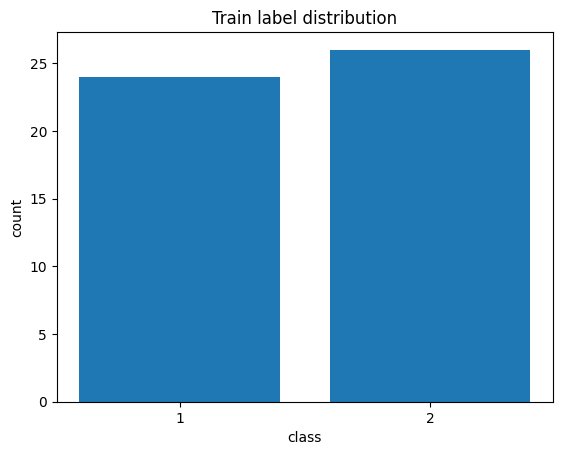


[Test label distribution] counts: {np.int64(1): np.int64(76), np.int64(2): np.int64(74)}


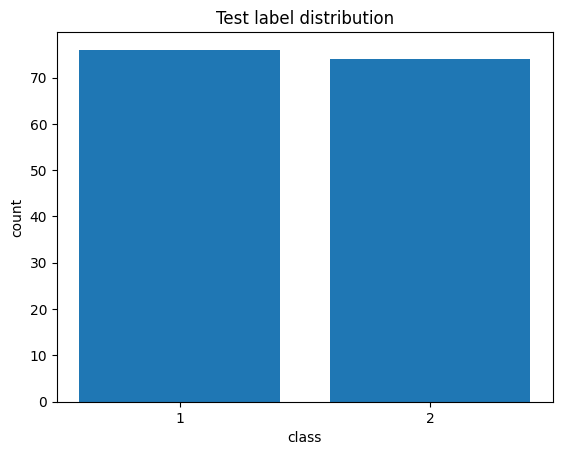

In [7]:
def label_hist(y, title):
    vals, counts = np.unique(y, return_counts=True)
    print(f"\n[{title}] counts:", dict(zip(vals, counts)))
    plt.figure()
    plt.bar(vals.astype(str), counts)
    plt.title(title)
    plt.xlabel("class")
    plt.ylabel("count")
    plt.show()


label_hist(y_train, "Train label distribution")
label_hist(y_test, "Test label distribution")

### 4) Visualize raw series: random samples per class


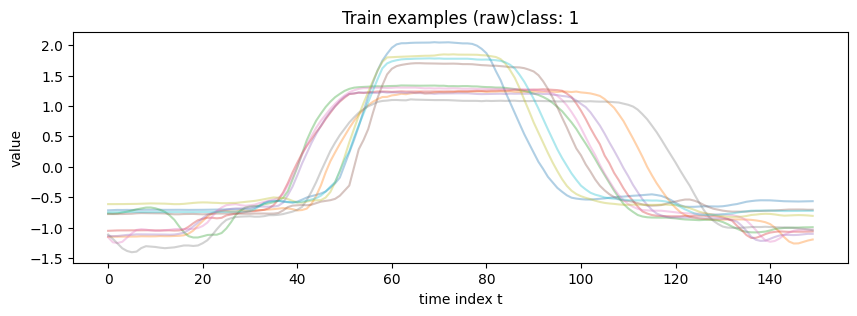

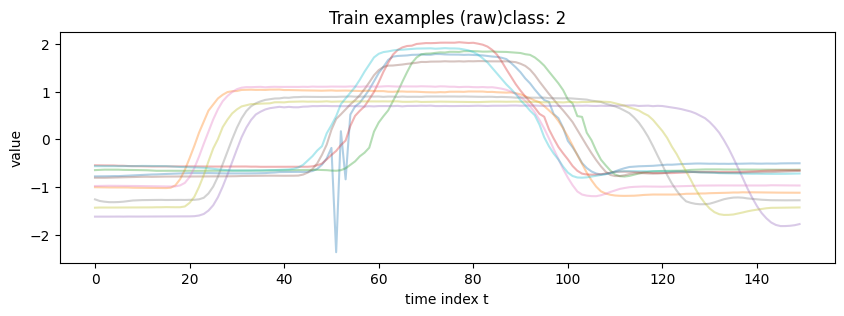

In [8]:
def plot_examples(X, y, n_per_class=5, title="Examples"):
    for i, c in enumerate(classes):
        plt.figure(figsize=(10, 3))
        idx = np.where(y == c)[0]
        pick = rng.choice(idx, size=min(n_per_class, len(idx)), replace=False)
        for j, k in enumerate(pick):
            plt.plot(X[k, :, 0], alpha=0.35)
        plt.title(title + " (raw)" + f"class: {c}")
        plt.xlabel("time index t")
        plt.ylabel("value")
        plt.show()


plot_examples(X_train, y_train, n_per_class=10, title="Train examples")

### 5) Class prototypes: mean ± std in time (raw)


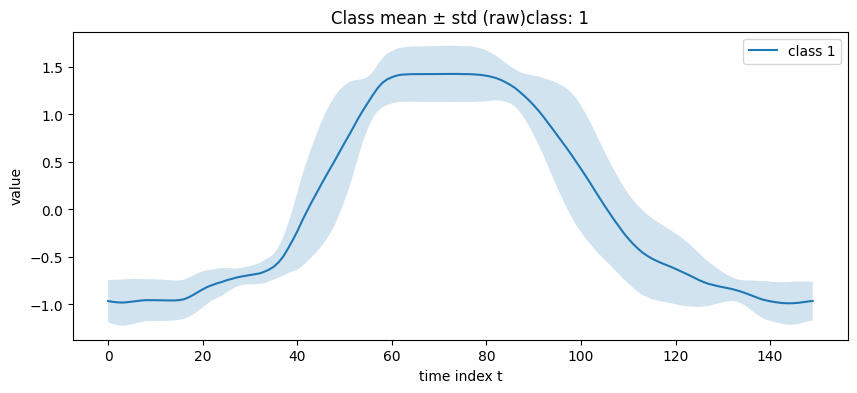

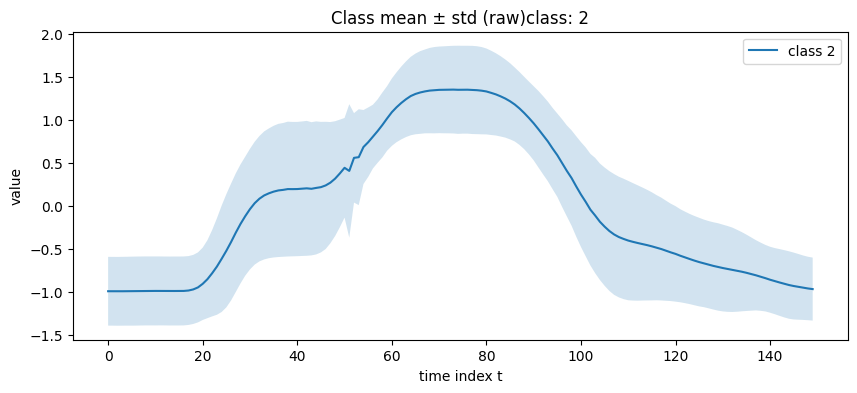

In [9]:
def plot_class_mean_std(X, y, title="Class mean ± std (raw)"):
    t = np.arange(X.shape[1])
    for c in classes:
        plt.figure(figsize=(10, 4))

        Xc = X[y == c, :, 0]
        mu = Xc.mean(axis=0)
        sd = Xc.std(axis=0)
        plt.plot(t, mu, label=f"class {c}")
        plt.fill_between(t, mu - sd, mu + sd, alpha=0.2)
        plt.title(title + f"class: {c}")
        plt.xlabel("time index t")
        plt.ylabel("value")
        plt.legend()
        plt.show()


plot_class_mean_std(X_train, y_train)

### 6) Scaling sensitivity check


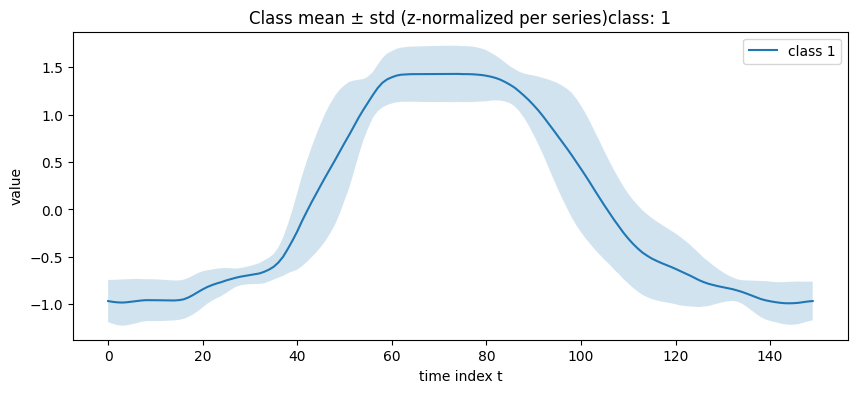

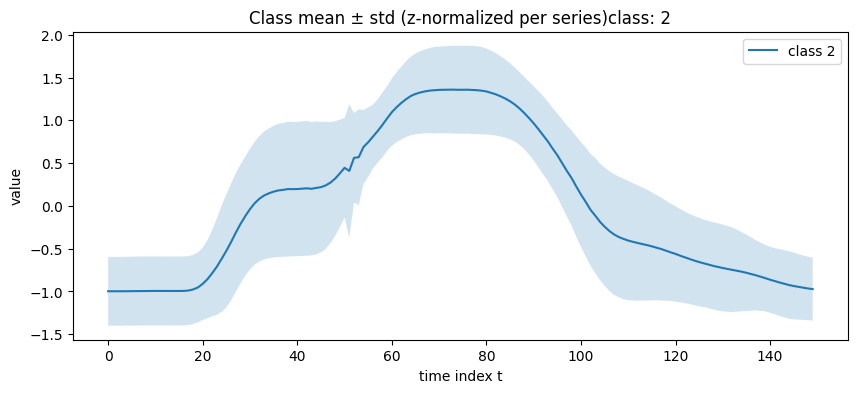

In [10]:
scaler = TimeSeriesScalerMeanVariance()  # per-series: mean=0, std=1
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

plot_class_mean_std(
    X_train_z, y_train, title="Class mean ± std (z-normalized per series)"
)

### 8) Distance-based separability (Euclidean vs DTW)


[Euclidean distance: within vs between]
  within  mean±std: 7.40201953237176 3.6175954540315325
  between mean±std: 8.127866348472152 2.571535705178693


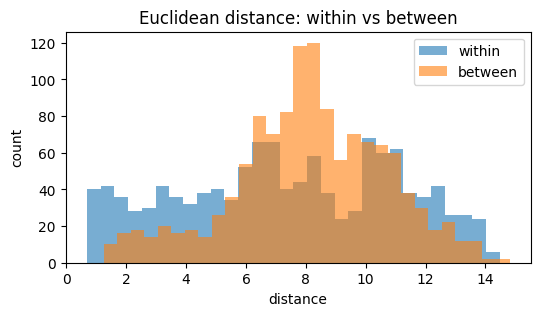


[DTW distance: within vs between]
  within  mean±std: 3.4744260594052077 2.502023909574379
  between mean±std: 3.6264694454315998 2.0577306324416362


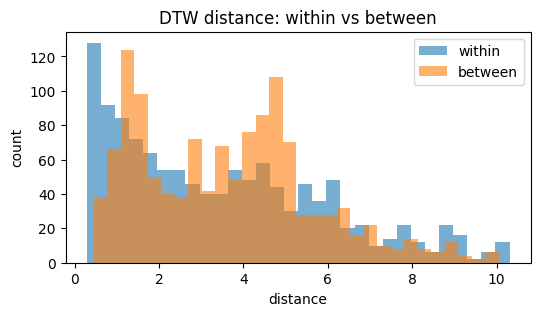

In [11]:
m = min(100, n_train)
idx = rng.choice(np.arange(n_train), size=m, replace=False)
X_sub = X_train[idx]
y_sub = y_train[idx]

Xv = X_sub.reshape(X_sub.shape[0], -1)  # (m, T*d)
D_euc = pairwise_distances(Xv, metric="euclidean")  # shape (m, m)

D_dtw = cdist_dtw(X_sub, X_sub)  # shape (m, m)


def within_between(D, y, title):
    mask_same = y[:, None] == y[None, :]
    mask_diff = ~mask_same
    # ignore diagonal
    np.fill_diagonal(mask_same, False)
    np.fill_diagonal(mask_diff, False)

    within = D[mask_same]
    between = D[mask_diff]

    print(f"\n[{title}]")
    print("  within  mean±std:", float(within.mean()), float(within.std()))
    print("  between mean±std:", float(between.mean()), float(between.std()))
    # quick visual
    plt.figure(figsize=(6, 3))
    plt.hist(within, bins=30, alpha=0.6, label="within")
    plt.hist(between, bins=30, alpha=0.6, label="between")
    plt.title(title)
    plt.xlabel("distance")
    plt.ylabel("count")
    plt.legend()
    plt.show()


within_between(D_euc, y_sub, "Euclidean distance: within vs between")
within_between(D_dtw, y_sub, "DTW distance: within vs between")

### 9) Minimal baselines (sanity)


In [12]:
# 1-NN Euclidean
knn_euc = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="euclidean")
knn_euc.fit(X_train, y_train)
acc_euc = knn_euc.score(X_test, y_test)


print("\nBaselines (test accuracy):")
print("  1-NN Euclidean:", acc_euc)


Baselines (test accuracy):
  1-NN Euclidean: 0.9133333333333333


In [13]:
# 1-NN DTW (can be slower, but GunPoint is small)
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn_dtw.fit(X_train, y_train)
acc_dtw = knn_dtw.score(X_test, y_test)

print("  1-NN DTW      :", acc_dtw)

  1-NN DTW      : 0.9066666666666666


# Experiments with tslearn.LearningShapelet implementation

## Part A - Run Grid Search

### CELL 0 — Imports + global config


In [14]:
import os, time, random, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path


import warnings

warnings.filterwarnings("ignore")

# Must be set BEFORE importing keras
os.environ["KERAS_BACKEND"] = "torch"

import keras

# keras.config.set_floatx("float32")

from keras.optimizers import Adam, AdamW
from keras.src.backend.torch.core import device_scope

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import PCA

from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

import torch

### CELL 1 — Small Utils


In [15]:
def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


def ensure_dir(p):
    p = pathlib.Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p


def cohen_d(x, y, eps=1e-12):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    sp = math.sqrt(((nx - 1) * vx + (ny - 1) * vy) / max(1, (nx + ny - 2)) + eps)
    return (x.mean() - y.mean()) / sp


def standardize_ucr_name(name: str):
    aliases = {
        "Gunpoint": "GunPoint",
        "gunpoint": "GunPoint",
        "TRACE": "Trace",
        "trace": "Trace",
        "ItalyPowerDemand": "ItalyPowerDemand",
    }
    return aliases.get(name, name)

### CELL 1b — Notebook configuration


In [16]:
keras_device = "cpu"  # pass "cpu" or "cuda"
# "mps" does not work with keras

# Data / output
dataset_name = "GunPoint"
scaler = "minmax"
out_dir = ensure_dir("results_shapelets_ucr_copy")

# Test subsample (keeps runtime low)
n_test_subsample = None
subsample_seed = 0

# ----------------------------
# Sweep / training params
# ----------------------------
# Convention: each sweep_* is a tuple of candidate values to try (grid search).
# We loop over all combinations (l, r, k_frac, max_iter, lr, reg) × seeds.

seeds = (0,)  # RNG seeds (repeat runs for stability if you add more)
sweep_l = (
    0.1,
    0.2,
)  # base shapelet length as a fraction of series length T (L_min = l * T)
sweep_r = (
    1,
)  # number of length scales (typically lengths are multiples of L_min, up to r scales)

# Shapelet count control:
# -1.0 means "use Grabocka/tslearn heuristic K_L for each length"
# otherwise, override to a fixed K = round(k_frac * T) shapelets per length (same K at all scales)
# pass 0.013 to get exactly 2 shapelets on GunPoint
sweep_k_frac = (0.013,)

sweep_max_iter = (1000,)  # training iterations (controls runtime + convergence)
sweep_lr = (1e-2,)  # learning rate for the optimizer
sweep_reg = (1e-2,)  # weight regularization strength (lambda_W)
batch_size = 1000  # batch size (large => fewer steps/epoch; limited by memory)

### CELL 2 — Data loading + preprocessing (+ optional test subsample)


In [17]:
def load_ucr(dataset_name="GunPoint", scaler="minmax"):
    dataset_name = standardize_ucr_name(dataset_name)
    ucr = UCR_UEA_datasets()
    X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)

    if scaler == "minmax":
        sc = TimeSeriesScalerMinMax()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    elif scaler == "zscore":
        sc = TimeSeriesScalerMeanVariance()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    elif scaler in (None, "none"):
        pass
    else:
        raise ValueError(f"Unknown scaler={scaler}")

    # convert to float32 to support mps
    # --> currently does not work
    # X_train = X_train.astype(np.float32)
    # X_test = X_test.astype(np.float32)

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    meta = {
        "dataset": dataset_name,
        "n_train": X_train.shape[0],
        "n_test": X_test.shape[0],
        "ts_len": X_train.shape[1],
        "n_channels": X_train.shape[2],
        "n_classes": len(np.unique(y_train_enc)),
        "classes": list(le.classes_),
        "label_encoder": le,
        "scaler": scaler,
    }
    return X_train, y_train_enc, X_test, y_test_enc, meta


def subsample_test_set(X_test, y_test, n_test_subsample=10, subsample_seed=0):
    if n_test_subsample is None or n_test_subsample >= len(y_test):
        meta_sub = {
            "n_test_full": len(y_test),
            "test_subsample_indices": list(range(len(y_test))),
        }
        return X_test, y_test, meta_sub

    rng = np.random.default_rng(subsample_seed)
    classes = np.unique(y_test)

    per_class = max(1, n_test_subsample // len(classes))
    chosen = []
    for c in classes:
        idx = np.where(y_test == c)[0]
        take = min(per_class, len(idx))
        chosen.extend(rng.choice(idx, size=take, replace=False).tolist())

    chosen = np.array(sorted(set(chosen)), dtype=int)
    if len(chosen) < n_test_subsample:
        remaining = np.setdiff1d(np.arange(len(y_test)), chosen, assume_unique=False)
        extra = rng.choice(
            remaining, size=n_test_subsample - len(chosen), replace=False
        )
        chosen = np.concatenate([chosen, extra])

    rng.shuffle(chosen)

    meta_sub = {"n_test_full": len(y_test), "test_subsample_indices": chosen.tolist()}
    return X_test[chosen], y_test[chosen], meta_sub

### CELL 2b — Use data functions immediately (load + subsample + meta)


In [18]:
with device_scope(keras_device):
    X_train, y_train, X_test, y_test, meta = load_ucr(dataset_name, scaler=scaler)
    X_test, y_test, meta_sub = subsample_test_set(
        X_test, y_test, n_test_subsample=n_test_subsample, subsample_seed=subsample_seed
    )

meta["n_test_full"] = meta_sub["n_test_full"]
meta["n_test"] = len(y_test)
meta["test_subsample_indices"] = meta_sub["test_subsample_indices"]

print("=== Dataset meta ===")
for k in [
    "dataset",
    "n_train",
    "n_test",
    "ts_len",
    "n_channels",
    "n_classes",
    "scaler",
]:
    print(f"{k}: {meta[k]}")
print(f"test set subsampled: {meta['n_test']} / {meta['n_test_full']}")
print("classes:", meta["classes"])

=== Dataset meta ===
dataset: GunPoint
n_train: 50
n_test: 150
ts_len: 150
n_channels: 1
n_classes: 2
scaler: minmax
test set subsampled: 150 / 150
classes: [np.int64(1), np.int64(2)]


### CELL 3 — Baselines (fit once)


In [19]:
def fit_baselines_once(X_train, y_train, X_test, y_test):
    print("=== Baselines (fit once) ===")

    knn_euc = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="euclidean")
    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")

    t0 = time.perf_counter()
    knn_euc.fit(X_train, y_train)
    fit_euc_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    knn_dtw.fit(X_train, y_train)
    fit_dtw_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    pred_euc = knn_euc.predict(X_test)
    pred_euc_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    pred_dtw = knn_dtw.predict(X_test)
    pred_dtw_s = time.perf_counter() - t0

    baselines = pd.DataFrame(
        [
            {
                "model": "1NN-euclidean",
                "test_acc": float(accuracy_score(y_test, pred_euc)),
                "test_bal_acc": float(balanced_accuracy_score(y_test, pred_euc)),
                "test_f1_macro": float(f1_score(y_test, pred_euc, average="macro")),
                "fit_s": fit_euc_s,
                "pred_s": pred_euc_s,
            },
            {
                "model": "1NN-dtw",
                "test_acc": float(accuracy_score(y_test, pred_dtw)),
                "test_bal_acc": float(balanced_accuracy_score(y_test, pred_dtw)),
                "test_f1_macro": float(f1_score(y_test, pred_dtw, average="macro")),
                "fit_s": fit_dtw_s,
                "pred_s": pred_dtw_s,
            },
        ]
    ).sort_values("test_acc", ascending=False)

    print(baselines.to_string(index=False))
    print()

    return baselines, knn_euc, knn_dtw

### CELL 3b — Use baselines immediately (fit once + save)


In [20]:
with device_scope(keras_device):
    baselines, knn_euc, knn_dtw = fit_baselines_once(X_train, y_train, X_test, y_test)

baselines.to_csv(out_dir / f"{meta['dataset']}_baselines.csv", index=False)

=== Baselines (fit once) ===
        model  test_acc  test_bal_acc  test_f1_macro    fit_s   pred_s
1NN-euclidean      0.90      0.900427       0.899960 0.040385 0.112855
      1NN-dtw      0.88      0.879801       0.879915 0.019481 3.988148



### CELL 4 — Shapelet training (single run) + sweep helper (no refit needed)


In [21]:
def override_shapelet_counts_with_k_frac(shapelet_sizes, ts_sz, k_frac):
    """Pass fixed fraction for number of shapelet for each shapelet length"""
    k_fixed = int(round(float(k_frac) * ts_sz))
    k_fixed = max(1, k_fixed)

    new_sizes = {int(L): k_fixed for L in shapelet_sizes.keys()}
    return new_sizes


def train_eval_shapelets(
    X_train,
    y_train,
    X_test,
    y_test,
    l=0.1,
    r=1,
    lr=1e-2,
    reg=1e-2,
    batch_size=16,
    max_iter=200,
    seed=0,
    verbose=0,
    device="cpu",  # optional: pass "cpu"/"mps"/"cuda:0"; if None, don't scope
    time_fit=True,
    time_pred=True,
    k_frac=-1.0,  # if > 0.0: override all K_L with int(k_frac * ts_sz)
):
    """Fit and evaluate model"""
    set_seed(seed)

    n_ts, ts_sz = X_train.shape[:2]
    n_classes = len(np.unique(y_train))

    # Compute shapelets sizes and numbers
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(
        n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=float(l), r=int(r)
    )

    # NEW: override counts per length with a fixed K = int(k_frac * ts_sz)
    if k_frac > 0.0:
        print(
            "k_frac is >0.0 meaning we don't use heuristic but fixed number for all shapelet lengths"
        )
        shapelet_sizes = override_shapelet_counts_with_k_frac(
            shapelet_sizes, ts_sz, k_frac=float(k_frac)
        )

    n_shapelets = int(sum(shapelet_sizes.values()))

    def _fit_and_eval():
        # Use tslearn.LearningShapelets
        # with AdamW instead of Adam as in original paper
        clf = LearningShapelets(
            n_shapelets_per_size=shapelet_sizes,
            optimizer=AdamW(lr),
            batch_size=batch_size,
            weight_regularizer=reg,
            max_iter=max_iter,
            random_state=seed,
            verbose=verbose,
        )

        t0 = time.perf_counter()
        clf.fit(X_train, y_train)
        fit_time = time.perf_counter() - t0 if time_fit else np.nan

        # predict timings
        t0 = time.perf_counter()
        pred_test = clf.predict(X_test)
        pred_time = time.perf_counter() - t0 if time_pred else np.nan

        pred_train = clf.predict(X_train)

        row = {
            "model": "LearningShapelets",
            "seed": int(seed),
            "l": float(l),
            "r": int(r),
            "lr": float(lr),
            "reg": float(reg),
            "batch_size": int(batch_size),
            "max_iter": int(max_iter),
            "k_frac": k_frac,  # NEW
            "n_shapelets": int(n_shapelets),
            "sizes": dict(shapelet_sizes),
            "fit_s": float(fit_time),
            "pred_s": float(pred_time),
            "train_acc": float(accuracy_score(y_train, pred_train)),
            "test_acc": float(accuracy_score(y_test, pred_test)),
            "test_bal_acc": float(balanced_accuracy_score(y_test, pred_test)),
            "test_f1_macro": float(f1_score(y_test, pred_test, average="macro")),
            "n_iter_": int(getattr(clf, "n_iter_", max_iter)),
        }
        return clf, row

    if device is None:
        return _fit_and_eval()
    else:
        with device_scope(device):
            return _fit_and_eval()

In [22]:
def fmt(v):
    # compact & stable-ish string formatting
    if v is None:
        return "None"
    if isinstance(v, float):
        return f"{v:.6g}"
    return str(v)


def make_key(params: dict) -> str:
    # alphabetical order of parameter names
    parts = []
    for name in sorted(params.keys()):
        parts.append(f"{name}_{fmt(params[name])}")
    return "_".join(parts)


def run_shapelet_sweep(
    X_train,
    y_train,
    X_test,
    y_test,
    sweep_l=(0.05, 0.10, 0.15, 0.20),
    sweep_r=(1, 2, 3),
    seeds=(0, 1, 2),
    sweep_lr=(1e-2,),
    sweep_reg=(1e-2,),
    sweep_max_iter=(200,),
    sweep_k_frac=(-1.0,),  # use -1.0 sentinel for "no override"
    batch_size=16,
    device="cpu",
    verbose=0,
    keep_models=True,
):
    """Perform grid search
    Return:
        sweep_df,
        agg_df,
        best_key,
        best_clf,
        best_row,
        model_store,
        best_key_str
    """
    print("=== Shapelet sweep (l, r, lr, reg, max_iter, k_frac) x seeds ===")
    sweep_rows = []

    best_acc = -np.inf
    best_key = None
    best_clf = None
    best_row = None

    # Store all models
    # Key: "batch_size_..._k_frac_..._l_..._lr_..._max_iter_..._r_..._reg_..._seed_..." -> clf
    model_store = {}

    # Maybe use itertools.product here instead
    for max_iter in sweep_max_iter:
        for lr in sweep_lr:
            for reg in sweep_reg:
                for k_frac in sweep_k_frac:
                    for l in sweep_l:
                        for r in sweep_r:
                            for seed in seeds:
                                clf, row = train_eval_shapelets(
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    l=l,
                                    r=r,
                                    lr=lr,
                                    reg=reg,
                                    batch_size=batch_size,
                                    max_iter=max_iter,
                                    seed=seed,
                                    verbose=verbose,
                                    device=device,
                                    k_frac=k_frac,
                                )
                                sweep_rows.append(row)

                                if keep_models:
                                    params = {
                                        # "batch_size": int(batch_size),
                                        "k_frac": float(k_frac),
                                        "l": float(l),
                                        "lr": float(lr),
                                        "max_iter": int(max_iter),
                                        "r": int(r),
                                        "reg": float(reg),
                                        "seed": int(seed),
                                    }
                                    key = make_key(params)
                                    model_store[key] = clf

                                if row["test_acc"] > best_acc:
                                    best_acc = row["test_acc"]
                                    best_key = {
                                        "l": float(l),
                                        "r": int(r),
                                        "lr": float(lr),
                                        "reg": float(reg),
                                        "max_iter": int(max_iter),
                                        "k_frac": (
                                            float(k_frac)
                                            if k_frac is not None
                                            else None
                                        ),
                                        "seed": int(seed),
                                    }
                                    best_clf = clf
                                    best_row = row
    # Create result dataframe
    sweep_df = pd.DataFrame(sweep_rows)

    agg_df = (
        sweep_df.groupby(["l", "r", "lr", "reg", "max_iter", "k_frac"], as_index=False)
        .agg(
            test_acc_mean=("test_acc", "mean"),
            test_acc_std=("test_acc", "std"),
            test_bal_acc_mean=("test_bal_acc", "mean"),
            f1_macro_mean=("test_f1_macro", "mean"),
            fit_s_mean=("fit_s", "mean"),
            n_shapelets=("n_shapelets", "mean"),
        )
        .sort_values(["test_acc_mean", "test_bal_acc_mean"], ascending=False)
    )

    print("\nTop configs (mean over seeds):")
    print(agg_df.head(10).to_string(index=False))

    print("\nBest single run:")
    print({**best_key, "best_test_acc": float(best_acc)})

    # optional: best_key_str if you want to fetch best model from model_store
    best_key_str = None
    if keep_models and best_key is not None:
        best_key_str = make_key({**best_key})

    return sweep_df, agg_df, best_key, best_clf, best_row, model_store, best_key_str

### CELL 4b — Run Grid Search


In [23]:
with device_scope(keras_device):
    sweep_df, agg_df, best_key, best_clf, best_row, model_store, best_key_str = (
        run_shapelet_sweep(
            X_train,
            y_train,
            X_test,
            y_test,
            sweep_l=sweep_l,
            sweep_r=sweep_r,
            seeds=seeds,
            sweep_max_iter=sweep_max_iter,
            sweep_lr=sweep_lr,
            sweep_reg=sweep_reg,
            sweep_k_frac=sweep_k_frac,
            batch_size=batch_size,
            device=None,  # or omit if you already wrap outside
            verbose=0,
            keep_models=True,
        )
    )


print("\n=== Best-model detailed metrics (seed=0) ===")
print(f"Best key: {best_key_str}")
print(pd.DataFrame([best_row]).to_string(index=False))

# Save results
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

sweep_df.to_csv(out_dir / f"{meta['dataset']}_sweep_raw_{timestamp}.csv", index=False)
agg_df.to_csv(out_dir / f"{meta['dataset']}_sweep_agg_{timestamp}.csv", index=False)

=== Shapelet sweep (l, r, lr, reg, max_iter, k_frac) x seeds ===
k_frac is >0.0 meaning we don't use heuristic but fixed number for all shapelet lengths
k_frac is >0.0 meaning we don't use heuristic but fixed number for all shapelet lengths

Top configs (mean over seeds):
  l  r   lr  reg  max_iter  k_frac  test_acc_mean  test_acc_std  test_bal_acc_mean  f1_macro_mean  fit_s_mean  n_shapelets
0.2  1 0.01 0.01      1000   0.013       0.853333           NaN           0.853307       0.853307   31.108809          2.0
0.1  1 0.01 0.01      1000   0.013       0.680000           NaN           0.684033       0.649874   25.317095          2.0

Best single run:
{'l': 0.2, 'r': 1, 'lr': 0.01, 'reg': 0.01, 'max_iter': 1000, 'k_frac': 0.013, 'seed': 0, 'best_test_acc': 0.8533333333333334}

=== Best-model detailed metrics (seed=0) ===
Best key: k_frac_0.013_l_0.2_lr_0.01_max_iter_1000_r_1_reg_0.01_seed_0
            model  seed   l  r   lr  reg  batch_size  max_iter  k_frac  n_shapelets   sizes     

### CELL 4f - Compute model memory
- Motivation was to check if it was reasonable to keep all models in the dictionary model_store
- Answer: yes they are small


In [24]:
def print_lts_model_size(clf, name="clf"):
    """
    Print a simple size estimate for a tslearn LearningShapelets model.
    Counts and sizes are for stored weights (not peak training memory).
    """
    # --- shapelets_ (numpy arrays) ---
    shp_params, shp_bytes = 0, 0
    if hasattr(clf, "shapelets_"):
        for s in clf.shapelets_:
            a = np.asarray(s)
            shp_params += int(np.prod(a.shape))
            shp_bytes += int(a.nbytes)

    # --- linear head weights (classification) ---
    head_params, head_bytes = 0, 0
    try:
        W, b = clf.get_weights("classification")
        W = np.asarray(W)
        b = np.asarray(b)
        head_params = int(np.prod(W.shape) + np.prod(b.shape))
        head_bytes = int(W.nbytes + b.nbytes)
    except Exception:
        pass

    total_params = shp_params + head_params
    total_bytes = shp_bytes + head_bytes
    total_mb = total_bytes / (1024**2)

    print(f"=== LearningShapelets model size: {name} ===")
    print(f"n_shapelets: {len(getattr(clf, 'shapelets_', []))}")
    print(
        f"shapelets:  params={shp_params:,}  bytes={shp_bytes:,}  ({shp_bytes/(1024**2):.3f} MB)"
    )
    print(
        f"head:       params={head_params:,}  bytes={head_bytes:,}  ({head_bytes/(1024**2):.3f} MB)"
    )
    print(
        f"TOTAL:      params={total_params:,} bytes={total_bytes:,} ({total_mb:.3f} MB)"
    )

In [25]:
print_lts_model_size(best_clf, name="best")

=== LearningShapelets model size: best ===
n_shapelets: 2
shapelets:  params=60  bytes=480  (0.000 MB)
head:       params=3  bytes=12  (0.000 MB)
TOTAL:      params=63 bytes=492 (0.000 MB)


In [26]:
model_store

{'k_frac_0.013_l_0.1_lr_0.01_max_iter_1000_r_1_reg_0.01_seed_0': LearningShapelets(batch_size=1000, max_iter=1000, n_shapelets_per_size={15: 2},
                   optimizer=<keras.src.optimizers.adamw.AdamW object at 0x30476f080>,
                   random_state=0, weight_regularizer=0.01),
 'k_frac_0.013_l_0.2_lr_0.01_max_iter_1000_r_1_reg_0.01_seed_0': LearningShapelets(batch_size=1000, max_iter=1000, n_shapelets_per_size={30: 2},
                   optimizer=<keras.src.optimizers.adamw.AdamW object at 0x30429ec00>,
                   random_state=0, weight_regularizer=0.01)}

### CELL 4b bis - save models


In [27]:
def save_shapelet_models(model_dict, destination_path="models", overwrite_models=False):
    """
    Serializes tslearn LearningShapelets models using joblib.

    Args:
        model_dict (dict): Dictionary where keys are parameter strings
                           and values are LearningShapelets instances.
        destination_path (str): Directory where .joblib files will be stored.
    """
    # Create the directory if it doesn't exist (Pathlib is cleaner for OS operations)
    output_dir = Path(destination_path)
    output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Starting serialization of {len(model_dict)} models...")

    for model_name, model_instance in model_dict.items():
        # Define the full file path
        file_path = output_dir / f"{model_name}.joblib"

        if (not overwrite_models) and file_path.exists():
            print(
                f"model key {file_path.name} already found at {file_path.parent}, not overwriting it"
            )
            continue
        else:
            try:
                # compress=3 is a good balance between speed and disk space
                joblib.dump(model_instance, file_path)
                print(f"Successfully saved: {model_name}.joblib")
            except Exception as e:
                print(f"Failed to save {model_name}: {e}")

    print(f"All models processed. Check directory: {output_dir.absolute()}")

In [28]:
save_shapelet_models(model_store, destination_path=out_dir / "models")

Starting serialization of 2 models...
model key k_frac_0.013_l_0.1_lr_0.01_max_iter_1000_r_1_reg_0.01_seed_0.joblib already found at results_shapelets_ucr_copy/models, not overwriting it
model key k_frac_0.013_l_0.2_lr_0.01_max_iter_1000_r_1_reg_0.01_seed_0.joblib already found at results_shapelets_ucr_copy/models, not overwriting it
All models processed. Check directory: /Users/tristan/3A/MVA/Time Series/Projet/Project-Learning-Shapelets/results_shapelets_ucr_copy/models


### CELL 4d - Plot results of grid search


In [29]:
def plot_two_cols_fixed(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    fixed_cols=None,
    ref_idx=0,
    fixed_vals=None,
    kind="line",  # "line" or "scatter"
    ax=None,
    savepath=None,
):
    """
    Plot y_col vs x_col on rows where fixed_cols are held constant.

    - fixed_cols: list of columns to keep equal (recommended: hyperparams other than x_col)
    - fixed_vals: optional dict {col: value}. If None, uses df.loc[ref_idx, fixed_cols]
    """
    if fixed_cols is None:
        # by default: fix everything except x and y
        fixed_cols = [c for c in df.columns if c not in {x_col, y_col}]

    if fixed_vals is None:
        fixed_vals = df.loc[ref_idx, fixed_cols].to_dict()

    mask = np.ones(len(df), dtype=bool)
    for c in fixed_cols:
        v = fixed_vals[c]
        if pd.isna(v):
            mask &= df[c].isna()
        elif isinstance(v, (float, np.floating)):
            mask &= np.isclose(df[c].astype(float), float(v))
        else:
            mask &= df[c].eq(v)

    sub = df.loc[mask].copy()
    if sub.empty:
        raise ValueError("No rows match the fixed values. Check fixed_cols/fixed_vals.")

    sub = sub.sort_values(x_col)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    if kind == "scatter":
        ax.scatter(sub[x_col], sub[y_col])
    else:
        ax.plot(sub[x_col], sub[y_col], "o-")

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    title = "Fixed: " + ", ".join([f"{c}={fixed_vals[c]}" for c in fixed_cols])
    ax.set_title(title, fontsize=10)
    ax.grid(alpha=0.3)

    # NEW: save
    if savepath is not None:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")

    return fig, ax, sub

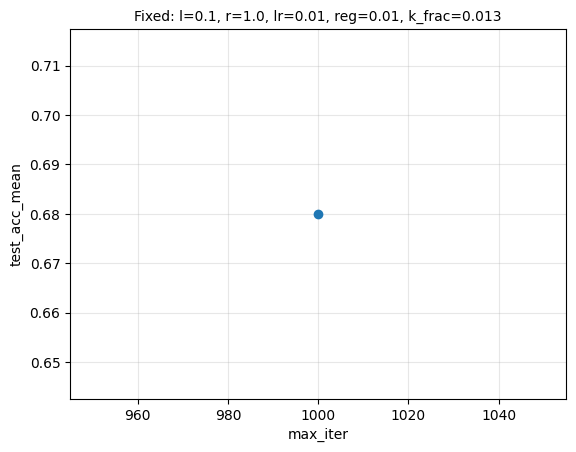

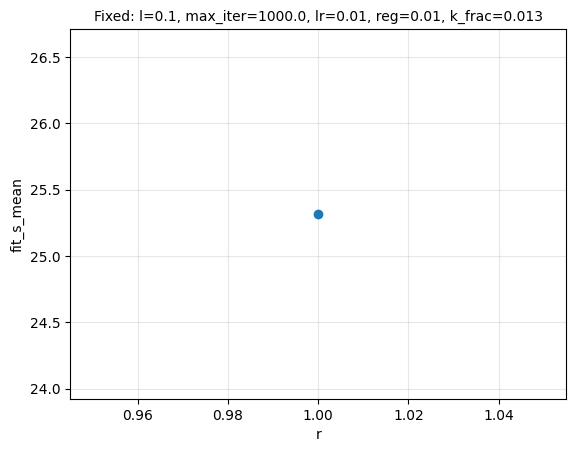

In [30]:
fig, ax, sub = plot_two_cols_fixed(
    agg_df,
    x_col="max_iter",
    y_col="test_acc_mean",
    fixed_cols=["l", "r", "lr", "reg", "k_frac"],
    ref_idx=0,
    savepath=out_dir / f"{meta['dataset']}_plot_acc_max_iter.png",
)
plt.show()

fig, ax, sub = plot_two_cols_fixed(
    agg_df,
    x_col="r",
    y_col="fit_s_mean",
    fixed_cols=["l", "max_iter", "lr", "reg", "k_frac"],
    ref_idx=0,
    savepath=out_dir / f"{meta['dataset']}_plot_time_max_iter.png",
)
plt.show()

## Part B - Visualizations

In [31]:
def load_shapelet_model(model_name, source_path="models"):
    """
    Load a serialized tslearn LearningShapelets model.
    """
    file_path = Path(source_path) / f"{model_name}.joblib"
    if not file_path.exists():
        raise FileNotFoundError(f"Model not found: {file_path}")

    model = joblib.load(file_path)
    return model

In [32]:
model_store

{'k_frac_0.013_l_0.1_lr_0.01_max_iter_1000_r_1_reg_0.01_seed_0': LearningShapelets(batch_size=1000, max_iter=1000, n_shapelets_per_size={15: 2},
                   optimizer=<keras.src.optimizers.adamw.AdamW object at 0x30476f080>,
                   random_state=0, weight_regularizer=0.01),
 'k_frac_0.013_l_0.2_lr_0.01_max_iter_1000_r_1_reg_0.01_seed_0': LearningShapelets(batch_size=1000, max_iter=1000, n_shapelets_per_size={30: 2},
                   optimizer=<keras.src.optimizers.adamw.AdamW object at 0x30429ec00>,
                   random_state=0, weight_regularizer=0.01)}

### CELL 4e - Choose model to plot visual


In [33]:
# best model
clf = best_clf
key = best_key_str

# another model
# key = "k_frac_-1_l_0.2_lr_0.01_max_iter_1000_r_3_reg_0.01_seed_0"
# key = "k_frac_-1_l_0.2_lr_0.01_max_iter_5000_r_3_reg_0.01_seed_0"
# key = "k_frac_0.15_l_0.2_lr_0.01_max_iter_1000_r_3_reg_0.01_seed_0"
# key = "k_frac_0.15_l_0.2_lr_0.01_max_iter_5000_r_3_reg_0.01_seed_0"
# clf = model_store[key]

# Create vizualisation dir
viz_dir = out_dir / f"viz_{key}"
viz_dir.mkdir(exist_ok=True)
print(f"Figures will be stored at {viz_dir}")

Figures will be stored at results_shapelets_ucr_copy/viz_k_frac_0.013_l_0.2_lr_0.01_max_iter_1000_r_1_reg_0.01_seed_0


### CELL 5 — Confusion and Loss


In [34]:
def plot_confusion(y_true, y_pred, title, savepath=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_loss_curve(clf, title="Training loss", savepath=None):
    hist = getattr(clf, "history_", None)
    if hist is None or "loss" not in hist:
        print("No loss history found on clf.history_.")
        return
    losses = np.asarray(hist["loss"], dtype=float)
    fig = plt.figure(figsize=(6, 3.5))
    plt.plot(np.arange(1, len(losses) + 1), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

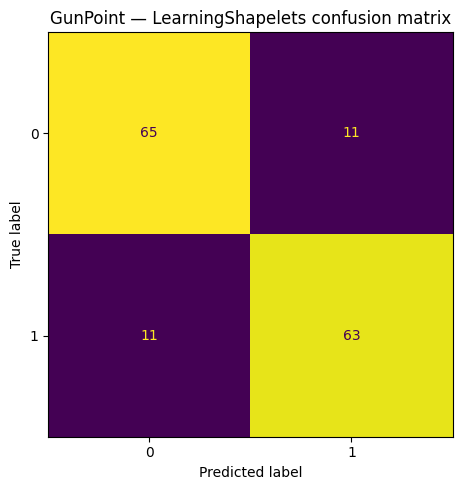

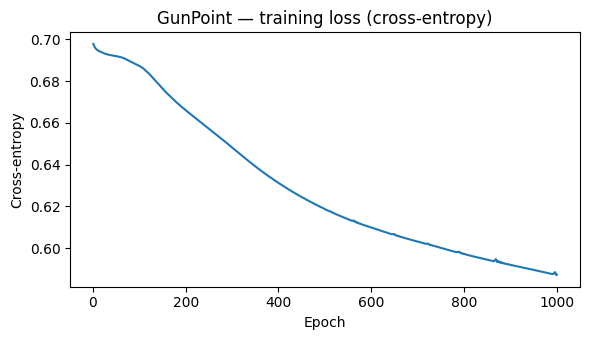

In [35]:
with device_scope(keras_device):
    y_pred = clf.predict(X_test)

plot_confusion(
    y_test,
    y_pred,
    title=f"{meta['dataset']} — LearningShapelets confusion matrix",
    savepath=viz_dir / f"{meta['dataset']}_confusion.png",
)

plot_loss_curve(
    clf,
    title=f"{meta['dataset']} — training loss (cross-entropy)",
    savepath=viz_dir / f"{meta['dataset']}_loss.png",
)

### CELL 6 — Shapelet interpretation
- shapelet importance, separation effect, top shapelets, PCA of shapelet transform


In [36]:
def get_classification_weights(clf):
    W, b = clf.get_weights("classification")
    return np.asarray(W), np.asarray(b)


def shapelet_importance_from_linear_head(W):
    if W.ndim == 1:
        return np.abs(W)
    return np.linalg.norm(W, axis=1)


def shapelet_effect_sizes(clf, X, y):
    D = clf.transform(X)
    classes = np.unique(y)
    eff = np.zeros(D.shape[1], dtype=float)
    for j in range(D.shape[1]):
        dj = D[:, j]
        best = 0.0
        for c in classes:
            in_c = dj[y == c]
            out_c = dj[y != c]
            d = cohen_d(in_c, out_c)
            if np.isfinite(d):
                best = max(best, abs(d))
        eff[j] = best
    return eff


def plot_top_shapelets(clf, top_idx, savepath=None):
    fig = plt.figure(figsize=(8, 1.9 * len(top_idx)))
    for k, j in enumerate(top_idx):
        ax = plt.subplot(len(top_idx), 1, k + 1)
        shp = np.asarray(clf.shapelets_[j]).ravel()
        ax.plot(shp)
        ax.set_title(f"Shapelet #{j} (length={len(shp)})")
        ax.set_xlim(0, len(shp) - 1)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_aligned_class_means(
    clf, X, y, shapelet_idx, n_per_class=30, title=None, savepath=None
):
    shp = np.asarray(clf.shapelets_[shapelet_idx]).ravel()
    L = len(shp)
    loc = clf.locate(X)

    classes = np.unique(y)
    fig = plt.figure(figsize=(7, 2.2 * len(classes)))
    for i, c in enumerate(classes):
        ax = plt.subplot(len(classes), 1, i + 1)
        idx = np.where(y == c)[0]
        if len(idx) > n_per_class:
            idx = np.random.choice(idx, size=n_per_class, replace=False)

        segs = []
        for t in idx:
            pos = int(loc[t, shapelet_idx])
            ts = X[t].ravel()
            if pos < 0:
                continue
            if pos + L <= len(ts):
                segs.append(ts[pos : pos + L])
        segs = np.asarray(segs)
        if segs.size == 0:
            ax.set_title(f"Class {c}: no segments extracted")
            continue

        m = segs.mean(axis=0)
        s = segs.std(axis=0)
        ax.plot(m, linewidth=2, label="mean aligned segment")
        ax.fill_between(np.arange(L), m - s, m + s, alpha=0.2, label="±1 std")
        ax.plot(shp, linewidth=2, linestyle="--", label="shapelet")
        ax.set_title(
            f"Class {c}: aligned segments vs shapelet (j={shapelet_idx}, L={L})"
        )
        ax.set_xlim(0, L - 1)
        ax.legend(loc="upper right", fontsize=9)

    if title:
        fig.suptitle(title, y=1.02)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


def plot_location_histograms(clf, X, y, shapelet_idx, bins=20, savepath=None):
    loc = clf.locate(X)
    positions = loc[:, shapelet_idx].astype(int)
    classes = np.unique(y)

    fig = plt.figure(figsize=(7, 2.2 * len(classes)))
    for i, c in enumerate(classes):
        ax = plt.subplot(len(classes), 1, i + 1)
        pos_c = positions[y == c]
        ax.hist(pos_c, bins=bins, alpha=0.8)
        ax.set_title(f"Match locations for shapelet #{shapelet_idx} in class {c}")
        ax.set_xlabel("Best-match start index")
        ax.set_ylabel("count")
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_distance_space_first2shapelets(clf, X, y, title, savepath=None):
    """
    Plot each time series in the 2D 'shapelet-distance space' defined by the
    FIRST TWO learned shapelets:
        (d(x, s1), d(x, s2))

    Requires: clf has at least 2 shapelets.
    """
    D = clf.transform(X)  # (N, K) where K = n_shapelets
    if D.shape[1] < 2:
        raise ValueError(
            f"Need at least 2 shapelets, but clf.transform(X) has shape {D.shape}"
        )

    Z = D[:, :2]  # use distances to first two shapelets directly

    fig = plt.figure(figsize=(6, 5))
    for c in np.unique(y):
        m = y == c
        plt.scatter(Z[m, 0], Z[m, 1], edgecolors="k", alpha=0.9, label=f"class {c}")

    plt.xlabel(r"$d(\mathbf{x}, \mathbf{s}_1)$")
    plt.ylabel(r"$d(\mathbf{x}, \mathbf{s}_2)$")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=200)

    plt.show()


def plot_distance_space_pca(clf, X, y, title, savepath=None):
    D = clf.transform(X)
    Z = PCA(n_components=2, random_state=0).fit_transform(D)

    fig = plt.figure(figsize=(6, 5))
    for c in np.unique(y):
        m = y == c
        plt.scatter(Z[m, 0], Z[m, 1], edgecolors="k", alpha=0.9, label=f"class {c}")
    plt.xlabel("PC1 (distances)")
    plt.ylabel("PC2 (distances)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

Top shapelets by linear-head importance (and effect size):
 shapelet_idx  length  importance_linear_head  separation_effect_max_abs_cohen_d
            1      30                1.727391                           1.432476
            0      30                1.266865                           1.760280


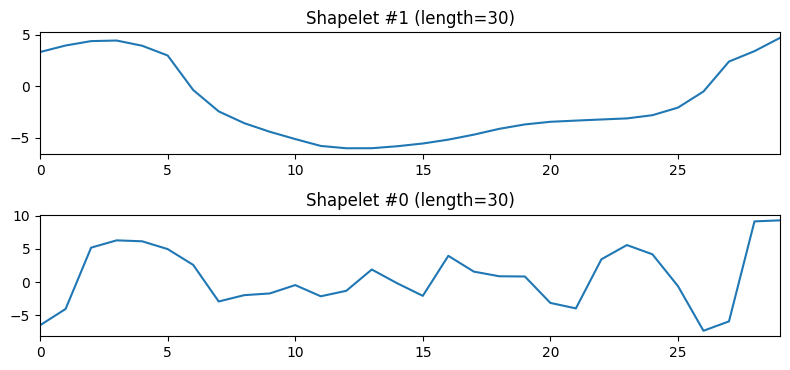

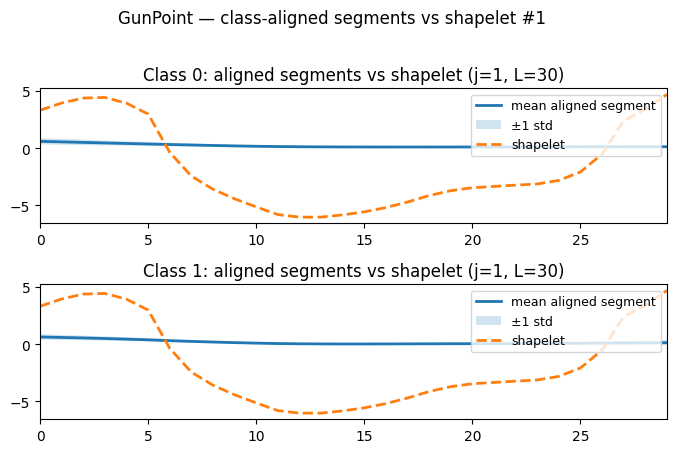

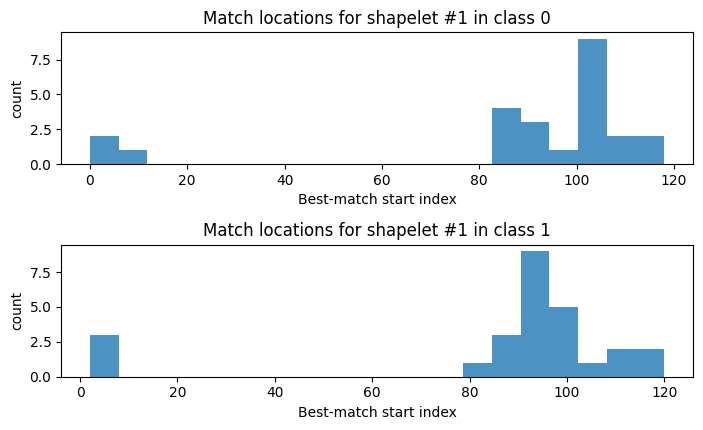

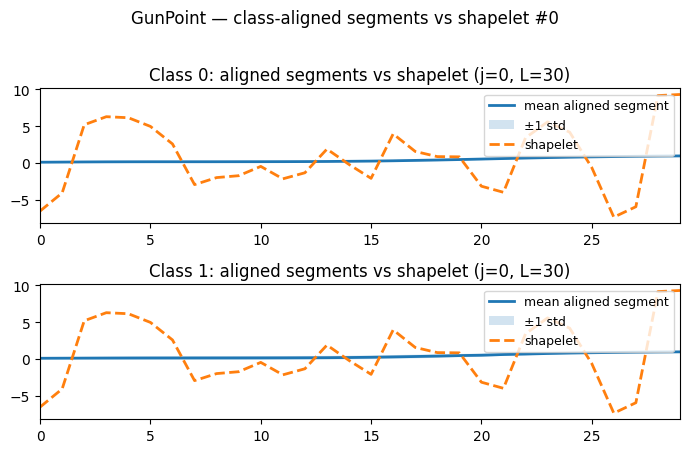

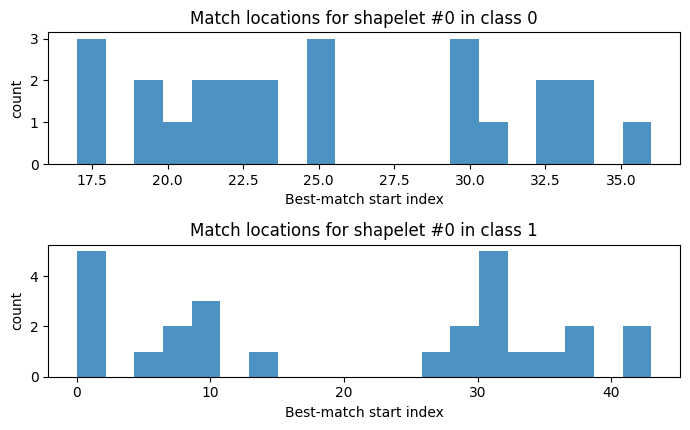

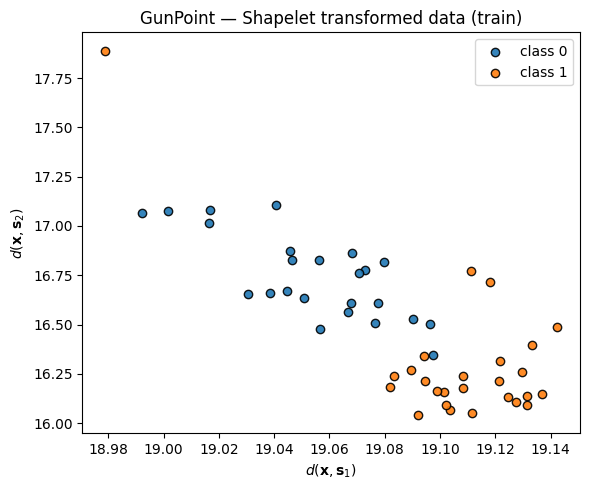

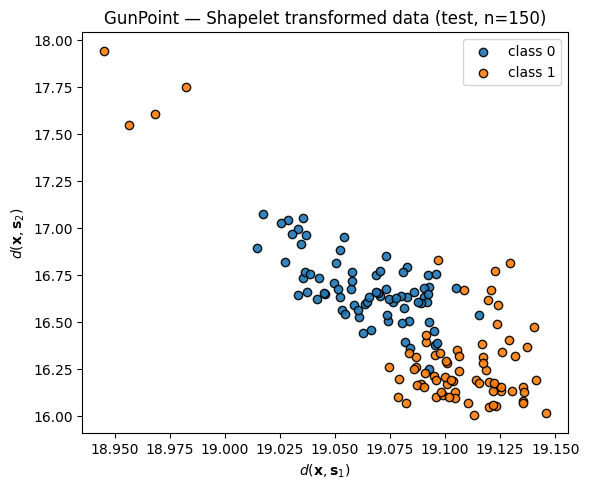

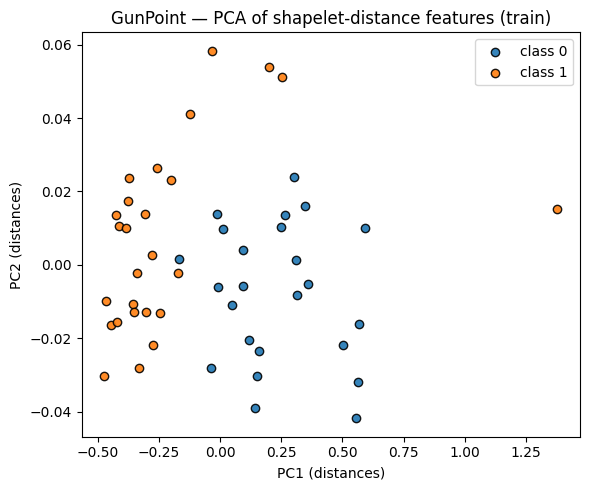

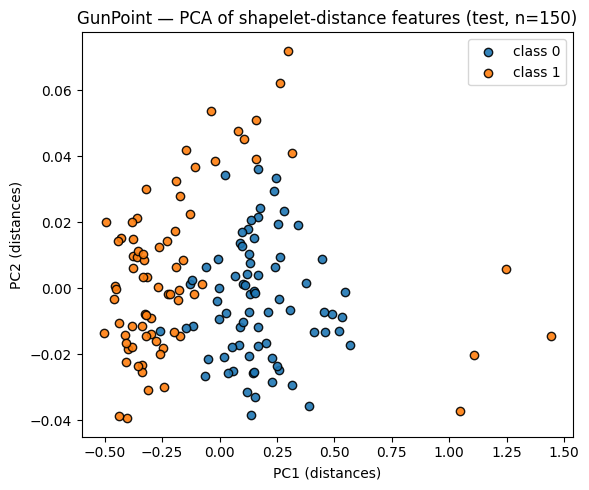

In [37]:
with device_scope(keras_device):
    W, b = get_classification_weights(clf)

    imp_w = shapelet_importance_from_linear_head(W)
    eff = shapelet_effect_sizes(clf, X_train, y_train)

    imp_df = pd.DataFrame(
        {
            "shapelet_idx": np.arange(len(imp_w)),
            "length": [len(np.asarray(s).ravel()) for s in clf.shapelets_],
            "importance_linear_head": imp_w,
            "separation_effect_max_abs_cohen_d": eff,
        }
    ).sort_values(
        ["importance_linear_head", "separation_effect_max_abs_cohen_d"], ascending=False
    )
    imp_df.to_csv(viz_dir / f"{meta['dataset']}_shapelet_importance.csv", index=False)

    print("Top shapelets by linear-head importance (and effect size):")
    print(imp_df.head(10).to_string(index=False))

    top_k = min(10, len(imp_df))
    top_idx = imp_df["shapelet_idx"].head(top_k).to_numpy()

    plot_top_shapelets(
        clf,
        top_idx,
        savepath=viz_dir / f"{meta['dataset']}_top_shapelets.png",
    )

    # plot for top shapelet
    # j = int(top_idx[0])
    for j in top_idx[: min(len(top_idx), 10)]:
        j = int(j)
        plot_aligned_class_means(
            clf,
            X_train,
            y_train,
            shapelet_idx=j,
            title=f"{meta['dataset']} — class-aligned segments vs shapelet #{j}",
            savepath=viz_dir / f"{meta['dataset']}_aligned_means_shapelet{j}.png",
        )

        plot_location_histograms(
            clf,
            X_train,
            y_train,
            shapelet_idx=j,
            savepath=viz_dir / f"{meta['dataset']}_locations_shapelet{j}.png",
        )

    # plot distance space
    plot_distance_space_first2shapelets(
        clf,
        X_train,
        y_train,
        title=f"{meta['dataset']} — Shapelet transformed data (train)",
        savepath=viz_dir / f"{meta['dataset']}_shapelet_distance_train.png",
    )

    plot_distance_space_first2shapelets(
        clf,
        X_test,
        y_test,
        title=f"{meta['dataset']} — Shapelet transformed data (test, n={len(y_test)})",
        savepath=viz_dir / f"{meta['dataset']}_shapelet_distance_test.png",
    )

    plot_distance_space_pca(
        clf,
        X_train,
        y_train,
        title=f"{meta['dataset']} — PCA of shapelet-distance features (train)",
        savepath=viz_dir / f"{meta['dataset']}_pca_distance_train.png",
    )

    plot_distance_space_pca(
        clf,
        X_test,
        y_test,
        title=f"{meta['dataset']} — PCA of shapelet-distance features (test, n={len(y_test)})",
        savepath=viz_dir / f"{meta['dataset']}_pca_distance_test.png",
    )

### CELL 6c - Shapelet overlapped on best match among time series


In [38]:
def _sliding_window_view_1d(x, L):
    """Compat helper: return shape (Q-L+1, L) windows."""
    try:
        return np.lib.stride_tricks.sliding_window_view(x, L)
    except Exception:
        # fallback (slower but robust)
        Q = len(x)
        return np.vstack([x[t : t + L] for t in range(Q - L + 1)])


def _distance_profile_mse(ts, shp_raw):
    """
    Model-faithful-ish distance profile: per-window mean squared error
    D_t = (1/L) * sum_{ell=1..L} (ts[t+ell] - shp[ell])^2
    """
    ts = np.asarray(ts).ravel()
    shp_raw = np.asarray(shp_raw).ravel()
    L = len(shp_raw)
    W = _sliding_window_view_1d(ts, L)  # (Q-L+1, L)
    return ((W - shp_raw) ** 2).mean(axis=1)


def _distance_profile_l2(ts, shp_plot):
    """Visualization distance profile: per-window L2 norm."""
    ts = np.asarray(ts).ravel()
    shp_plot = np.asarray(shp_plot).ravel()
    L = len(shp_plot)
    W = _sliding_window_view_1d(ts, L)
    return np.linalg.norm(W - shp_plot, axis=1)


def _softmin_from_profile(D, alpha=-100.0):
    """
    Soft-min of a distance profile D using weights exp(alpha * D).
    Stable implementation (shift in exponent).
    Returns scalar.
    """
    D = np.asarray(D, dtype=float)
    u = alpha * D
    u = u - np.max(u)  # stability
    w = np.exp(u)
    return float(np.sum(D * w) / (np.sum(w) + 1e-12))


def plot_shapelet_on_best_matches(
    clf,
    X,
    y=None,
    shapelet_idx=0,
    n_examples=6,
    per_class=True,
    pick="closest",  # "closest" or "random"
    seed=0,
    rescale_shapelet="none",  # "none" or "minmax"
    show_distance_curve=None,  # None/False, "l2", "softmin", or "both"
    alpha=-100.0,  # used for soft-min annotation in "softmin"/"both"
    savepath=None,
):
    """
    Plot one shapelet overlaid on several time series at the model best-match location.

    Layout:
      - if show_distance_curve == "softmin": add softmin/MSE profile below
      - if show_distance_curve == "l2": add L2 profile below
      - if show_distance_curve == "both": add 2 profiles below (3 rows total)

    X-axis alignment:
      - overlay uses time index 0..Q-1
      - distance profiles are plotted against window START index (0..Q-L),
    """
    rng = np.random.default_rng(seed)

    # raw shapelet (1D)
    shp_raw = np.asarray(clf.shapelets_[shapelet_idx]).ravel()
    L = len(shp_raw)

    # model distances + locations
    D_all = clf.transform(X)  # (n_samples, n_shapelets)
    loc = clf.locate(X)  # (n_samples, n_shapelets)
    dist_j = D_all[:, shapelet_idx]
    pos_j = loc[:, shapelet_idx].astype(int)

    # choose indices to plot
    if per_class and (y is not None):
        classes = np.unique(y)
        k = int(np.ceil(n_examples / len(classes)))
        chosen = []
        for c in classes:
            idx_c = np.where(y == c)[0]
            if len(idx_c) == 0:
                continue
            if pick == "closest":
                order = idx_c[np.argsort(dist_j[idx_c])]
                chosen.extend(order[: min(k, len(order))].tolist())
            elif pick == "random":
                chosen.extend(
                    rng.choice(idx_c, size=min(k, len(idx_c)), replace=False).tolist()
                )
            else:
                raise ValueError("pick must be 'closest' or 'random'")
        chosen = chosen[:n_examples]
    else:
        idx_all = np.arange(X.shape[0])
        if pick == "closest":
            chosen = idx_all[np.argsort(dist_j)][:n_examples].tolist()
        elif pick == "random":
            chosen = rng.choice(
                idx_all, size=min(n_examples, len(idx_all)), replace=False
            ).tolist()
        else:
            raise ValueError("pick must be 'closest' or 'random'")

    # shapelet for plotting
    if rescale_shapelet == "minmax":
        shp_plot = (
            TimeSeriesScalerMinMax().fit_transform(shp_raw.reshape(1, -1, 1)).ravel()
        )
    elif rescale_shapelet == "none":
        shp_plot = shp_raw
    else:
        raise ValueError("rescale_shapelet must be 'none' or 'minmax'")

    # how many rows per example
    if not show_distance_curve:
        rows_per_ex = 1
        modes = []
    elif show_distance_curve == "l2":
        rows_per_ex = 2
        modes = ["l2"]
    elif show_distance_curve == "softmin":
        rows_per_ex = 2
        modes = ["softmin"]
    elif show_distance_curve == "both":
        rows_per_ex = 3
        modes = ["softmin", "l2"]
    else:
        raise ValueError(
            "show_distance_curve must be None/False, 'l2', 'softmin', or 'both'"
        )

    n = len(chosen)
    nrows = n * rows_per_ex
    fig_h = (2.4 + (1.6 * (rows_per_ex - 1))) * max(1, n)
    fig, axes = plt.subplots(nrows, 1, figsize=(12, fig_h), squeeze=False)

    def ax_block(example_idx, subrow):
        """subrow: 0=overlay, 1=softmin OR l2 (if rows_per_ex==2), 2=l2 (if rows_per_ex==3)."""
        return axes[example_idx * rows_per_ex + subrow, 0]

    for ex, i in enumerate(chosen):
        ts = np.asarray(X[i]).ravel()
        Q = len(ts)

        # model best-match start index
        pos_model = int(pos_j[i])
        pos_model = max(0, min(pos_model, Q - L))

        # ----- Row 0: overlay -----
        ax0 = ax_block(ex, 0)
        ax0.plot(ts, linewidth=1.2)
        ax0.axvline(pos_model, linestyle="--", alpha=0.35, label="model locate")
        ax0.plot(np.arange(pos_model, pos_model + L), shp_plot, linewidth=2)

        label_str = f"idx={i}, d_model={dist_j[i]:.4f}"
        if y is not None:
            label_str += f", y={y[i]}"
        ax0.set_title(
            f"Best match overlay ({label_str}), pick={pick}, shapelet_idx={shapelet_idx}, L={L}"
        )
        ax0.set_xlim(0, Q - 1)

        # share x within the block
        if rows_per_ex > 1:
            ax1 = ax_block(ex, 1)
            ax1.sharex(ax0)
        if rows_per_ex > 2:
            ax2 = ax_block(ex, 2)
            ax2.sharex(ax0)

        # Rows 1 and 2: profiles
        if show_distance_curve:
            # Softmin/MSE profile (raw shapelet)
            if "softmin" in modes:
                ax_s = ax_block(ex, 1 if rows_per_ex == 3 else 1)
                dcurve = _distance_profile_mse(ts, shp_raw)
                xw = np.arange(len(dcurve))  # window start indices
                pos_curve = int(np.argmin(dcurve))
                hard = float(np.min(dcurve))
                soft = _softmin_from_profile(dcurve, alpha=alpha)

                ax_s.plot(xw, dcurve, linewidth=1.2)
                ax_s.axvline(
                    pos_curve,
                    linestyle="--",
                    alpha=0.35,
                    label="argmin (hard-min)",
                    color="green",
                )
                ax_s.axvline(
                    pos_model,
                    linestyle=":",
                    alpha=0.35,
                    label="model locate",
                    color="orange",
                )
                # ax_s.axhline(hard, linestyle=":", alpha=0.45, label="hard-min value")
                # ax_s.axhline(soft, linestyle="-.", alpha=0.55, label="soft-min value")
                ax_s.set_title(
                    f"Softmin view (MSE profile, raw shapelet): hard={hard:.4g}, soft={soft:.4g} (α={alpha:g})"
                )
                ax_s.set_xlim(0, Q - 1)
                ax_s.legend(loc="upper left", fontsize=8)

            # L2 profile (plotted shapelet)
            if "l2" in modes:
                ax_l = ax_block(ex, 2 if rows_per_ex == 3 else 1)
                dcurve = _distance_profile_l2(ts, shp_plot)
                xw = np.arange(len(dcurve))
                pos_curve = int(np.argmin(dcurve))
                hard = float(np.min(dcurve))

                ax_l.plot(xw, dcurve, linewidth=1.2)
                ax_l.axvline(pos_curve, linestyle="--", alpha=0.35, label="argmin (L2)")
                ax_l.axvline(pos_model, linestyle=":", alpha=0.35, label="model locate")
                ax_l.set_title(
                    f"L2 view (vs plotted shapelet, rescale={rescale_shapelet}): min={hard:.4g}"
                )
                ax_l.set_xlim(0, Q - 1)
                ax_l.set_xlabel("time / window start index")
                ax_l.legend(loc="upper left", fontsize=8)

        # tiny legend on overlay
        ax0.legend(loc="upper left", fontsize=8)

    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()
    return chosen

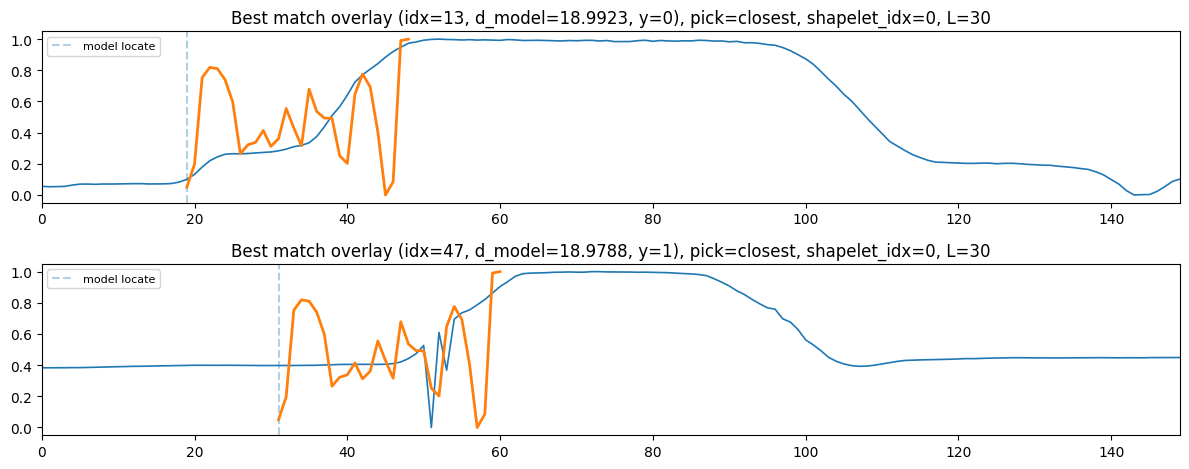

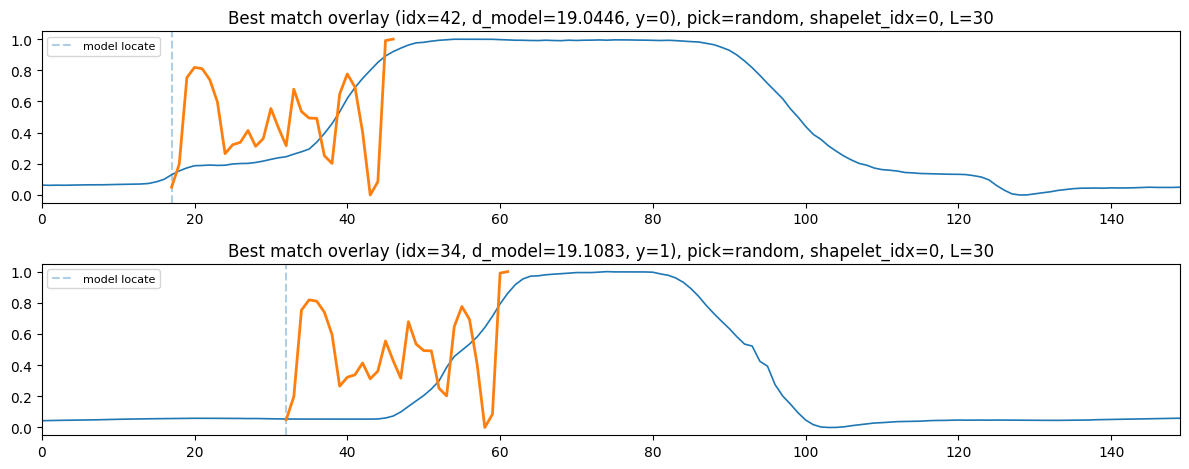

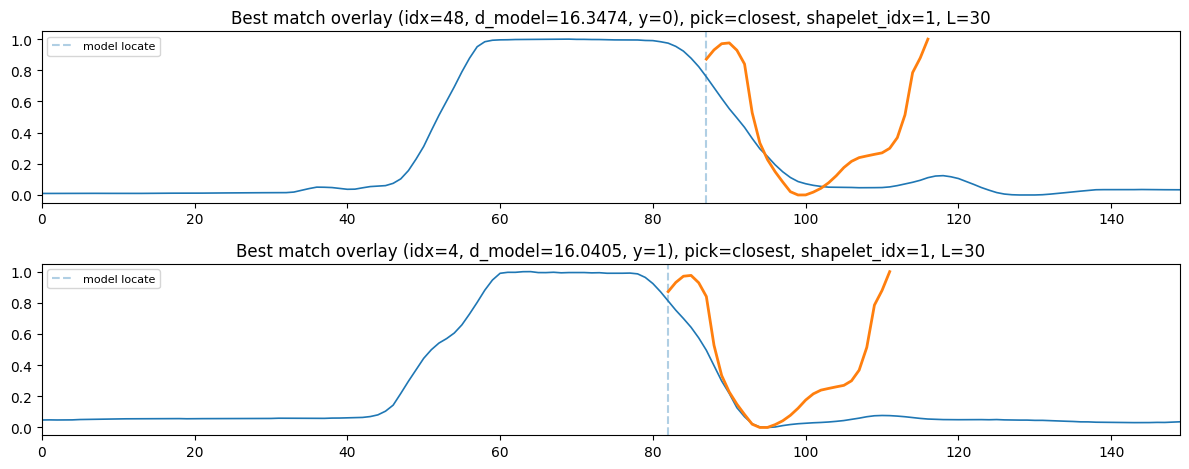

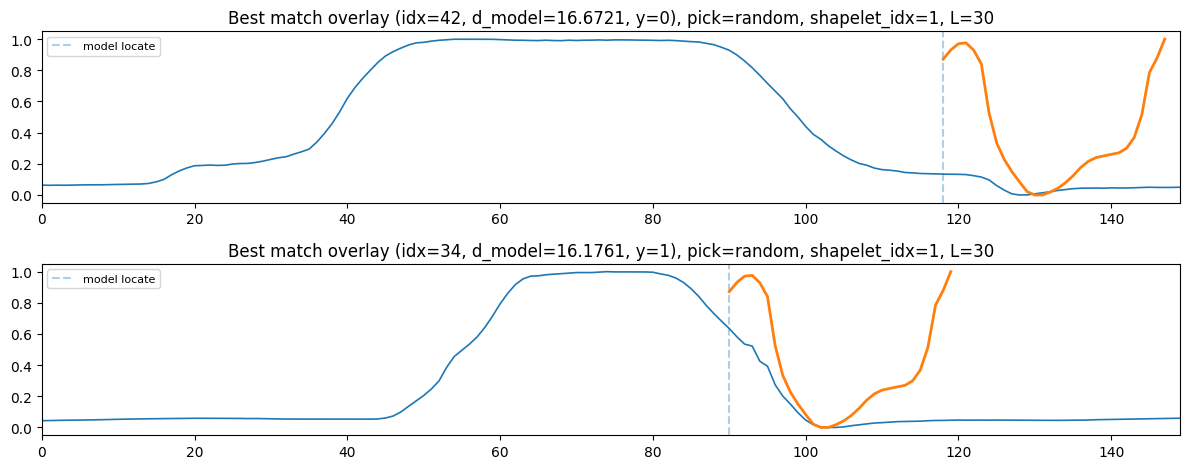

In [39]:
with device_scope(keras_device):
    for shapelet_idx in range(min(10, len(clf.shapelets_))):
        # show the most convincing matches, split per class
        plot_shapelet_on_best_matches(
            clf,
            X_train,
            y=y_train,
            shapelet_idx=shapelet_idx,
            n_examples=2,
            per_class=True,
            pick="closest",
            rescale_shapelet="minmax",  # or "none"
            show_distance_curve=False,  # set True if you want the distance curve panel
            savepath=viz_dir / f"shapelet_on_best_match_shp_idx_{shapelet_idx}_a.png",
        )

        plot_shapelet_on_best_matches(
            clf,
            X_train,
            y=y_train,
            shapelet_idx=shapelet_idx,
            n_examples=2,
            per_class=True,
            pick="random",
            rescale_shapelet="minmax",  # or "none"
            show_distance_curve=False,  # set True if you want the distance curve panel
            savepath=viz_dir / f"shapelet_on_random_shp_idx_{shapelet_idx}.png",
        )

### CELL 6d - Distribution of distance to shapelet i

In [40]:
def plot_shapelet_distance_distribution(
    clf,
    X,
    y=None,
    shapelet_idx=0,
    title=None,
    bins=40,
    show_percentiles=(1, 5, 10, 25, 50, 75, 90, 95, 99),
    highlight_indices=None,  # list/array of sample indices to mark
    figsize=(10, 4),
    savepath=None,
):
    """
    Plot dataset-wide distribution of the model distance to one shapelet.
    Distances come from clf.transform(X)[:, shapelet_idx] (i.e., the model feature).

    Parameters
        y : optional labels
        highlight_indices : optional

    Returns
        {percentiles, highlights}
    """
    # ensure X is accepted by clf.transform (tslearn expects (N,Q,dim))
    D = np.asarray(clf.transform(X))  # (N, K)
    dj = np.asarray(D[:, shapelet_idx], dtype=float)
    dj = dj[np.isfinite(dj)]
    if dj.size == 0:
        raise ValueError("No finite distances found (dj is empty).")

    # percentiles
    pct_vals = {p: float(np.percentile(dj, p)) for p in show_percentiles}

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    # main histogram
    ax.hist(dj, bins=bins, density=True, alpha=0.35, edgecolor="k", linewidth=0.3)

    # optional per-class overlays
    if y is not None:
        y = np.asarray(y)
        classes = np.unique(y)
        for c in classes:
            dj_c = np.asarray(D[y == c, shapelet_idx], dtype=float)
            dj_c = dj_c[np.isfinite(dj_c)]
            if dj_c.size == 0:
                continue
            ax.hist(
                dj_c,
                bins=bins,
                density=True,
                histtype="step",
                linewidth=1.5,
                label=f"class {c} (n={dj_c.size})",
            )

    # percentile lines
    ymax = ax.get_ylim()[1]
    for p, v in pct_vals.items():
        ax.axvline(v, linestyle="--", alpha=0.45)
        ax.text(v, 0.98 * ymax, f"{p}%", rotation=90, va="top", ha="right", fontsize=8)

    # highlight specific samples
    reports = []
    if highlight_indices is not None:
        highlight_indices = np.asarray(highlight_indices, dtype=int).ravel()
        D_full = np.asarray(D[:, shapelet_idx], dtype=float)
        # for percentile rank: fraction of dataset distances <= value
        for i in highlight_indices:
            if i < 0 or i >= D_full.shape[0] or not np.isfinite(D_full[i]):
                continue
            val = float(D_full[i])
            pct_rank = 100.0 * float(np.mean(dj <= val))
            ax.axvline(val, linestyle="-", linewidth=2.0, alpha=0.8, color="red")
            ax.text(
                val,
                0.6 * ymax,
                f"i={i}\n{pct_rank:.1f}%",
                rotation=90,
                va="center",
                ha="left",
                fontsize=8,
            )
            reports.append({"i": int(i), "d_model": val, "percentile_rank": pct_rank})

    # labels / title
    if title is None:
        title = f"Shapelet {shapelet_idx} — distribution of d_model = clf.transform(X)[:, {shapelet_idx}]"
    ax.set_title(title)
    ax.set_xlabel("Model distance to shapelet")
    ax.set_ylabel("Density")
    if y is not None:
        ax.legend(loc="best", fontsize=9)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

    return {"percentiles": pct_vals, "highlights": reports}

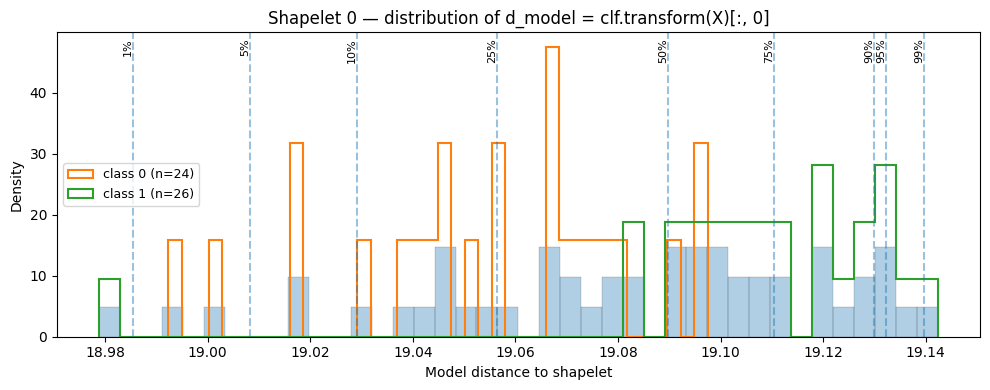

[]


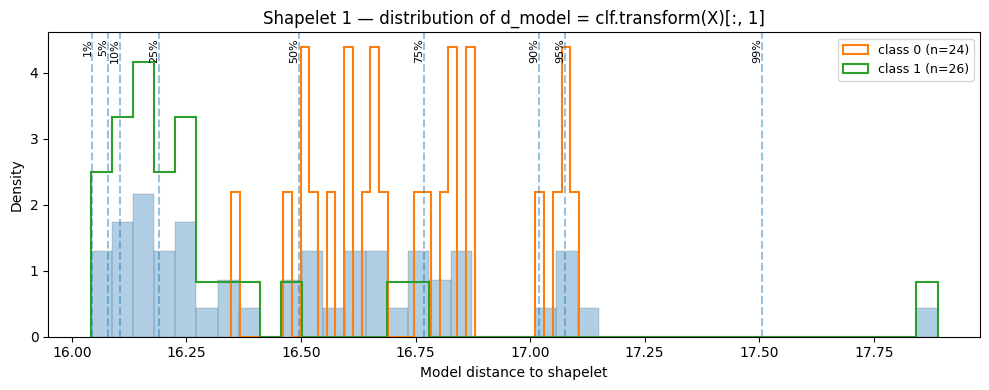

[]


In [41]:
with device_scope(keras_device):
    # highlight the exact series you plotted in your overlay function:
    chosen = [21, 26]  # for example
    for shapelet_idx in range(min(10, len(clf.shapelets_))):
        out = plot_shapelet_distance_distribution(
            clf,
            X_train,
            y_train,
            shapelet_idx=shapelet_idx,
            highlight_indices=[],
            savepath=viz_dir
            / f"shapelet_distance_distribution_shp_idx_{shapelet_idx}.png",
        )
        print(out["highlights"])

### CELL 6e - overlap shapelet with time series without rescaling


In [42]:
def plot_in_model_raw_space(
    clf,
    X,
    y=None,
    i=0,  # time series index
    shapelet_idx=0,
    show_zoom=True,
):
    """
    Visualize (time series, shapelet) in the exact raw space used by the model:
      - no shapelet rescaling
      - location = clf.locate(X)
      - overlay raw shapelet on raw preprocessed series
    """
    ts = np.asarray(X[i]).ravel()
    shp_raw = np.asarray(clf.shapelets_[shapelet_idx]).ravel()
    L = len(shp_raw)

    # model-best start index
    pos = int(np.asarray(clf.locate(X))[i, shapelet_idx])
    pos = max(0, min(pos, len(ts) - L))

    # model distance feature (scalar)
    d_model = float(np.asarray(clf.transform(X))[i, shapelet_idx])

    # figure
    if show_zoom:
        fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharex=False)
        ax0, ax1 = axes
    else:
        fig, ax0 = plt.subplots(1, 1, figsize=(11, 3.5))
        ax1 = None

    title = f"Raw model space overlay: i={i}, shapelet={shapelet_idx}, d_model={d_model:.4g}, pos={pos}"
    if y is not None:
        title += f", y={y[i]}"
    ax0.set_title(title)

    # full series + overlay
    ax0.plot(ts, linewidth=1.2)
    ax0.axvline(pos, linestyle="--", alpha=0.4)
    ax0.plot(np.arange(pos, pos + L), shp_raw, linewidth=2.0)
    ax0.set_xlim(0, len(ts) - 1)
    ax0.set_xlabel("time")
    ax0.set_ylabel("value")

    # zoom on matched window
    if show_zoom:
        seg = ts[pos : pos + L]
        ax1.plot(np.arange(L), seg, linewidth=1.5, label="segment (ts[pos:pos+L])")
        ax1.plot(np.arange(L), shp_raw, linewidth=2.0, label="raw shapelet")
        ax1.set_title("Zoom: matched window vs raw shapelet (same raw space)")
        ax1.set_xlabel("within-window time")
        ax1.set_ylabel("value")
        ax1.legend()

    plt.tight_layout()
    plt.show()

    return {"pos": pos, "d_model": d_model}

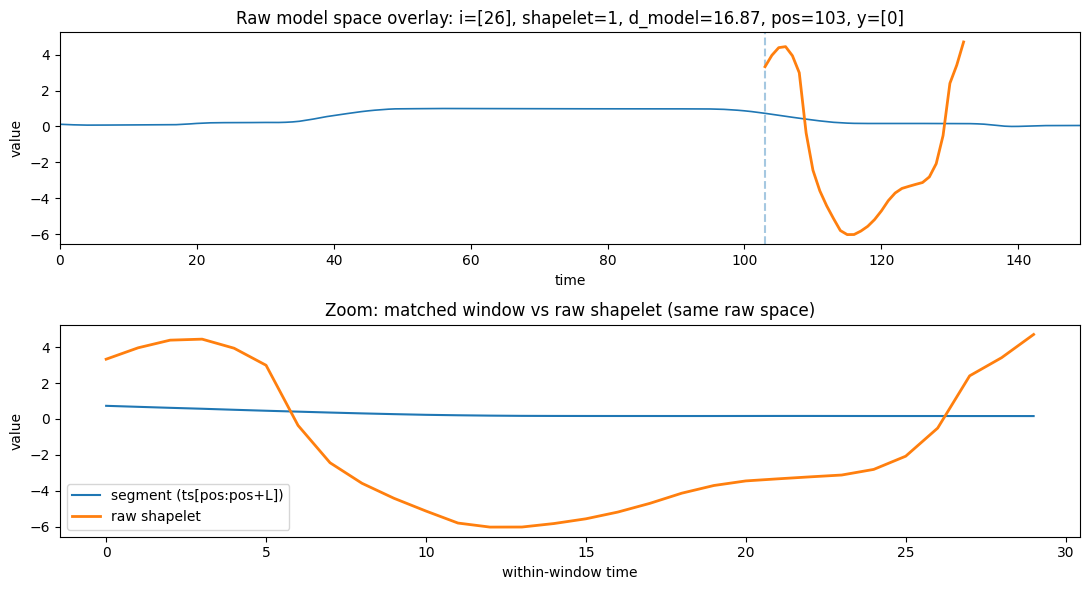

In [43]:
with device_scope(keras_device):
    # pick one of your "chosen" indices
    plot_in_model_raw_space(
        clf, X_train, y_train, i=[26], shapelet_idx=1, show_zoom=True
    )

### CELL 7 — Tests of robustness
- Evaluate models on test set with time shifts or gaussian noise


In [44]:
def circular_shift(X, rng, max_shift=None):
    Xs = X.copy()
    T = X.shape[1]
    if max_shift is None:
        max_shift = T - 1
    for i in range(X.shape[0]):
        k = int(rng.integers(low=0, high=max_shift + 1))
        Xs[i, :, 0] = np.roll(Xs[i, :, 0], shift=k)
    return Xs


def add_gaussian_noise(X, rng, sigma_rel=0.1):
    Xn = X.copy()
    sigma = sigma_rel * float(X.std())
    Xn += rng.normal(0.0, sigma, size=X.shape).astype(X.dtype)
    return Xn


def robustness_curve(
    model_predict_fn, X_test, y_test, transforms, title, savepath=None
):
    rows = []
    for name, Xmod in transforms:
        pred = model_predict_fn(Xmod)
        rows.append(
            {
                "condition": name,
                "acc": float(accuracy_score(y_test, pred)),
                "bal_acc": float(balanced_accuracy_score(y_test, pred)),
                "f1_macro": float(f1_score(y_test, pred, average="macro")),
            }
        )
    df = pd.DataFrame(rows)

    fig = plt.figure(figsize=(7, 3.5))
    plt.plot(df["condition"], df["acc"], marker="o", label="accuracy")
    plt.plot(df["condition"], df["bal_acc"], marker="o", label="balanced acc")
    plt.ylim(0.0, 1.01)
    plt.xticks(rotation=25, ha="right")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

    return df

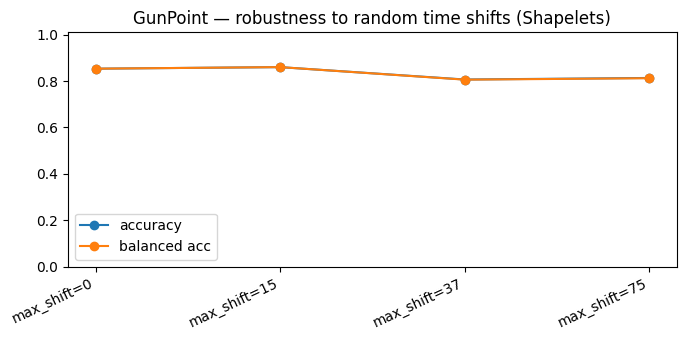

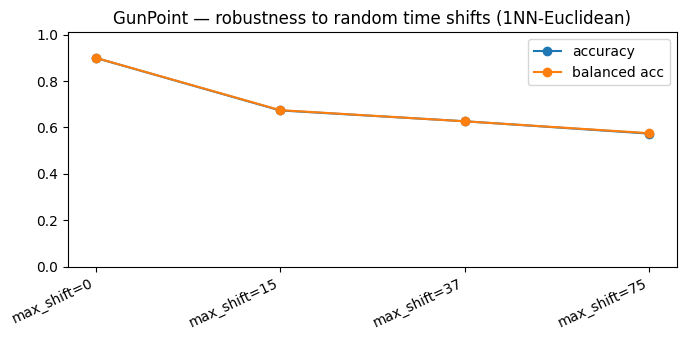

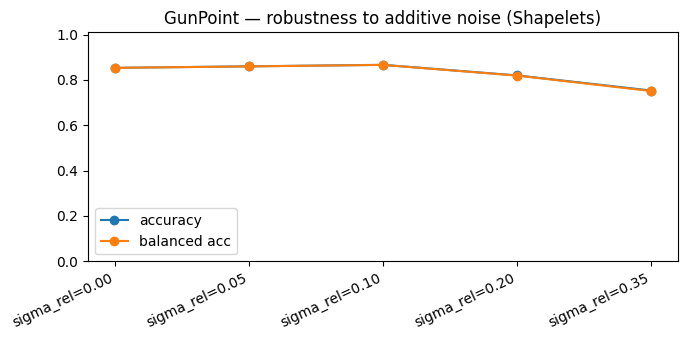

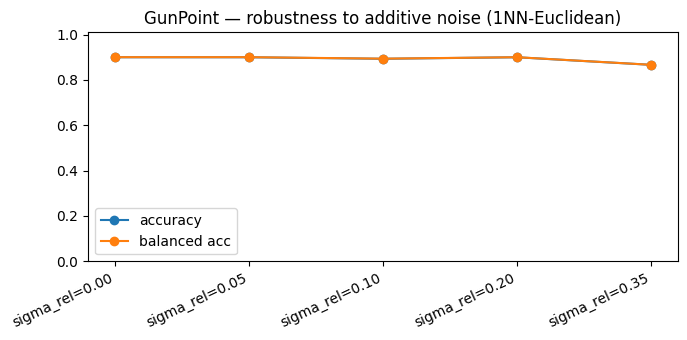

Saved robustness CSVs.


In [45]:
with device_scope(keras_device):
    # (A) Random circular shifts
    shifts = [
        0,
        int(0.1 * meta["ts_len"]),
        int(0.25 * meta["ts_len"]),
        int(0.5 * meta["ts_len"]),
    ]
    shift_transforms = []
    rng = np.random.default_rng(0)
    for s in shifts:
        Xs = X_test if s == 0 else circular_shift(X_test, rng=rng, max_shift=s)
        shift_transforms.append((f"max_shift={s}", Xs))

    df_shift_shapelets = robustness_curve(
        model_predict_fn=lambda X: clf.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=shift_transforms,
        title=f"{meta['dataset']} — robustness to random time shifts (Shapelets)",
        savepath=viz_dir / f"{meta['dataset']}_robust_shift_shapelets.png",
    )

    df_shift_euc = robustness_curve(
        model_predict_fn=lambda X: knn_euc.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=shift_transforms,
        title=f"{meta['dataset']} — robustness to random time shifts (1NN-Euclidean)",
        savepath=out_dir / f"{meta['dataset']}_robust_shift_1nn_euc.png",
    )

    # (B) Additive noise
    sigmas = [0.0, 0.05, 0.10, 0.20, 0.35]
    noise_transforms = []
    rng = np.random.default_rng(0)
    for s in sigmas:
        Xn = X_test if s == 0 else add_gaussian_noise(X_test, rng=rng, sigma_rel=s)
        noise_transforms.append((f"sigma_rel={s:.2f}", Xn))

    df_noise_shapelets = robustness_curve(
        model_predict_fn=lambda X: clf.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=noise_transforms,
        title=f"{meta['dataset']} — robustness to additive noise (Shapelets)",
        savepath=viz_dir / f"{meta['dataset']}_robust_noise_shapelets.png",
    )

    df_noise_euc = robustness_curve(
        model_predict_fn=lambda X: knn_euc.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=noise_transforms,
        title=f"{meta['dataset']} — robustness to additive noise (1NN-Euclidean)",
        savepath=out_dir / f"{meta['dataset']}_robust_noise_1nn_dtw.png",
    )

    df_shift_shapelets.to_csv(
        viz_dir / f"{meta['dataset']}_robust_shift_shapelets.csv", index=False
    )
    df_shift_euc.to_csv(
        out_dir / f"{meta['dataset']}_robust_shift_1nn_euc.csv", index=False
    )
    df_noise_shapelets.to_csv(
        viz_dir / f"{meta['dataset']}_robust_noise_shapelets.csv", index=False
    )
    df_noise_euc.to_csv(
        out_dir / f"{meta['dataset']}_robust_noise_1nn_dtw.csv", index=False
    )

    print("Saved robustness CSVs.")

# Pytorch Optimization

## Part A: Global Setup and Data Loading

In this section, we set up the environment, define configuration parameters, and implement helper functions to load datasets from the UCR/UEA archive. We also perform MinMax scaling, which is crucial for distance-based algorithms to function correctly.

### 1. Configuration and Hyperparameters

Defining global constants for the dataset (default: GunPoint), optimizer settings, and shapelet parameters.

In [46]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- CONFIGURATION ---
DATASET_NAME = "GunPoint"  # Change this to "GunPoint", "Coffee", "ECG200", etc.
SCALER = "minmax"          # "minmax", "zscore", or None
N_TEST_SUBSAMPLE = None    # Set to None for full test set, or int (e.g., 50)
SUBSAMPLE_SEED = 42


# Model Hyperparameters
K_SHAPELETS = 9           # Number of shapelets
SHAPELET_LEN_RATIO = 0.3   # Shapelet length as a fraction of time series length
ITERATIONS = 800
LR = 0.01
LAMBDA_W = 0.01            # Weight decay for linear layer
OPTIMIZER_NAME = 'AdamW'   # 'SGD' or 'AdamW'
INIT_MODE = 'random'    # 'random' or 'kmeans' or 'noise'
ALPHA = -100.0               # Sharpness parameter for soft-minimum

print(f"Configuration set for dataset: {DATASET_NAME}")

Configuration set for dataset: GunPoint


### 2) Data Loading & Preprocessing

We utilize tslearn to fetch datasets. The data is normalized so that all time series values fall within [0,1].

In [47]:
# CELL 2b — Use data functions immediately

# Load Data
X_train, y_train, X_test, y_test, meta = load_ucr(DATASET_NAME, scaler=SCALER)

# Subsample Test Set (if configured)
X_test, y_test, meta_sub = subsample_test_set(
    X_test, y_test, n_test_subsample=N_TEST_SUBSAMPLE, subsample_seed=SUBSAMPLE_SEED
)

# Merge Meta Info
meta["n_test_full"] = meta_sub["n_test_full"]
meta["n_test"] = len(y_test)
meta["test_subsample_indices"] = meta_sub["test_subsample_indices"]

# Calculate Dynamic Shapelet Length (e.g., 30% of TS length)
# We ensure it is at least 1
calculated_shapelet_len = max(1, int(meta['ts_len'] * SHAPELET_LEN_RATIO))

print("=== Dataset meta ===")
for k in ["dataset", "n_train", "n_test", "ts_len", "n_classes", "scaler"]:
    print(f"{k}: {meta[k]}")
print(f"Shapelet Params: K={K_SHAPELETS}, L={calculated_shapelet_len} (Ratio: {SHAPELET_LEN_RATIO})")

=== Dataset meta ===
dataset: GunPoint
n_train: 50
n_test: 150
ts_len: 150
n_classes: 2
scaler: minmax
Shapelet Params: K=9, L=45 (Ratio: 0.3)


## Part B: PyTorch Model Definition of Learning Shapelets

In this section, we define the core neural network architecture. The model is designed to learn a set of discriminative subsequences (shapelets) that can classify time series based on local similarity.

### 1. Mathematical Formulation

The model learns a set of $K$ shapelets, denoted as $S$. The fundamental operation is calculating the distance between a time series $T_i$ and a shapelet $S_k$. This is defined as the minimum squared Euclidean distance across all possible sliding windows of the time series.

However, the standard `min` operator is non-differentiable, which prevents backpropagation. To solve this, we use the differentiable **Soft-Minimum** function:

$$
M_{k,i} \approx \frac{\sum_{j} d_{k,i,j} \cdot e^{\alpha \cdot d_{k,i,j}}}{\sum_{j} e^{\alpha \cdot d_{k,i,j}}}
$$

Where:
* $d_{k,i,j}$ is the squared Euclidean distance between the $k$-th shapelet and the $j$-th segment of the $i$-th time series.
* $\alpha$ (typically set to -100) controls the sharpness of the approximation. As $\alpha \to -\infty$, the function approaches the true hard minimum.

### 2. Implementation Details

Our custom PyTorch implementation introduces several architectural optimizations:

* **`ShapeletBlock`**: A specialized module dedicated to a specific shapelet length $L$. It utilizes `torch.unfold` to vectorize the sliding window extraction, allowing the model to compute distances for all windows in parallel without loop overhead.
* **`LearningShapeletsModel`**: The main container that aggregates multiple `ShapeletBlock` instances (enabling multi-scale shapelets of different lengths) and passes the resulting distance vector to a linear classifier.
* **Initialization**: We implement distinct strategies to study convergence behavior:
    * `random_noise`: Initializes shapelets with Gaussian noise (used to demonstrate the vanishing gradient failure mode).
    * `random_window`: Initializes shapelets by copying random subsequences from the training data (ensures immediate valid gradient flow).

In [48]:
class ShapeletBlock(nn.Module):
    """
    A single block responsible for shapelets of a SPECIFIC length.
    """
    def __init__(self, n_shapelets, shapelet_length):
        super(ShapeletBlock, self).__init__()
        self.n_shapelets = n_shapelets
        self.shapelet_length = shapelet_length
        # Initialize random weights for this block
        self.shapelets = nn.Parameter(torch.randn(n_shapelets, shapelet_length))
        
    def forward(self, x, alpha):
        # x: (Batch, Time)
        # 1. Unfold specifically for THIS length
        x_unfolded = x.unfold(1, self.shapelet_length, 1)
        
        # 2. Compute Distances
        x_expanded = x_unfolded.unsqueeze(2)
        s_expanded = self.shapelets.view(1, 1, self.n_shapelets, self.shapelet_length)
        
        dist_sq = torch.sum((x_expanded - s_expanded) ** 2, dim=3)
        dist_sq = dist_sq / self.shapelet_length 
        
        # 3. Soft-Min
        weights = torch.exp(alpha * dist_sq)
        soft_min_dist = torch.sum(dist_sq * weights, dim=1) / (torch.sum(weights, dim=1) + 1e-8)
        
        return soft_min_dist


class LearningShapeletsModel(nn.Module):
    def __init__(self, shapelets_dict, input_length, num_classes, alpha):
        """
        Args:
            shapelets_dict: Dictionary {length: number_of_shapelets}
                            e.g. {20: 3, 40: 5} -> 3 shapelets of len 20, 5 of len 40
        """
        super(LearningShapeletsModel, self).__init__()
        
        self.alpha = alpha
        self.blocks = nn.ModuleList()
        
        total_shapelets = 0
        
        # Create a block for each length size
        for length, count in shapelets_dict.items():
            self.blocks.append(ShapeletBlock(n_shapelets=count, shapelet_length=length))
            total_shapelets += count
            
        # Linear layer takes the concatenation of ALL shapelet distances
        self.linear = nn.Linear(total_shapelets, num_classes)
        
    def forward(self, x):
        features = []
        # Loop through each length-block
        for block in self.blocks:
            # Each block handles its own unfolding and distance calculation
            features.append(block(x, self.alpha))
            
        # Concatenate all distances: (Batch, Total_K)
        all_features = torch.cat(features, dim=1)
        
        output = self.linear(all_features)
        return output, all_features

    def initialize_random_noise(self):
        """
        Explicitly initializes shapelets with Random Gaussian Noise.
        Used to demonstrate the Vanishing Gradient problem.
        """
        print(f"-> Initializing shapelets via Random Gaussian Noise (Standard Normal)...")
        for block in self.blocks:
            # Re-sample from N(0, 1)
            block.shapelets.data = torch.randn(
                block.n_shapelets, 
                block.shapelet_length, 
                dtype=torch.float32
            )
        print("-> Shapelets reset to pure noise.")

    def initialize_random_windows(self, X_train):
        print(f"-> Initializing shapelets via Random Window Sampling...")
        
        # Loop through each block to initialize its specific shapelets
        for block in self.blocks:
            n_shp = block.n_shapelets
            length = block.shapelet_length
            
            # Logic similar to before, but adapted for the block
            n_samples = X_train.shape[0]
            ts_len = X_train.shape[-1] if X_train.ndim == 2 else X_train.shape[1]
            
            random_ts_indices = np.random.choice(n_samples, n_shp, replace=True)
            random_start_times = np.random.randint(0, ts_len - length, n_shp)
            
            initial_shapelets = []
            for i in range(n_shp):
                ts_idx = random_ts_indices[i]
                start = random_start_times[i]
                
                if X_train.ndim == 2:
                    window = X_train[ts_idx, start : start + length]
                else:
                    window = X_train[ts_idx, start : start + length, 0]
                initial_shapelets.append(window)
                
            block.shapelets.data = torch.tensor(np.array(initial_shapelets), dtype=torch.float32)
            
        print(f"-> All shapelet blocks initialized.")

    def initialize_kmeans(self, X_train):
        print(f"-> Running K-Means initialization per block...")
        limit_windows = 10000 
        
        for block in self.blocks:
            length = block.shapelet_length
            n_shp = block.n_shapelets
            
            print(f"   Block (L={length}): extracting windows...")
            
            windows = []
            n_samples = min(X_train.shape[0], 200)
            
            for i in range(n_samples): 
                for j in range(X_train.shape[1] - length + 1):
                    windows.append(X_train[i, j:j+length])
            
            windows = np.array(windows)
            if len(windows) > limit_windows:
                idx = np.random.choice(len(windows), limit_windows, replace=False)
                windows = windows[idx]
                
            kmeans = TimeSeriesKMeans(n_clusters=n_shp, metric="euclidean", max_iter=50, verbose=0)
            kmeans.fit(windows)
            
            block.shapelets.data = torch.tensor(kmeans.cluster_centers_.squeeze(), dtype=torch.float32)

## Part C: Comparative Analysis (GunPoint)

In this section, we train our PyTorch implementation and compare it against the standard tslearn library implementation on the binary GunPoint dataset.

### Paramater dictionary definition

In [49]:
param_dict = {
    'K_SHAPELETS': K_SHAPELETS,
    'calculated_shapelet_len': calculated_shapelet_len,
    'meta': meta,
    'LAMBDA_W': LAMBDA_W,
    'LR': LR,
    'OPTIMIZER_NAME': OPTIMIZER_NAME,
    'ITERATIONS': ITERATIONS,
    'INIT_MODE': INIT_MODE,
    'shapelets_dict': {calculated_shapelet_len: K_SHAPELETS//2 , calculated_shapelet_len//2: K_SHAPELETS//2},
    'ALPHA': ALPHA
}

### Test data formating Helper Functions

In [50]:
def pt_model_data(X,y):
    X_sq = X.squeeze()
    if X_sq.ndim == 1: X_sq = X_sq.unsqueeze(1)
    
    X_tensor = torch.tensor(X_sq, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor

def ts_model_data(X,y):
    X_sq = X.squeeze()
    if X_sq.ndim == 2: X_sq = X_sq[:, :, np.newaxis]
    return X_sq, y

def override_shapelet_counts_with_k_frac(shapelet_sizes, ts_sz, k_frac):
    """
    Overrides the default Grabocka counts.
    Sets the number of shapelets for EACH length to int(k_frac * ts_sz).
    """
    k_fixed = int(k_frac * ts_sz)
    # Ensure at least 1 shapelet if k_frac is small but non-zero
    k_fixed = max(1, k_fixed) 
    
    new_sizes = {}
    for length in shapelet_sizes.keys():
        new_sizes[length] = k_fixed
    return new_sizes

In [51]:
if 'shapelets_dict' not in param_dict or param_dict['shapelets_dict'] is None:
    print(f"-> 'shapelets_dict' not found. Calculating via Grabocka heuristics...")
    n_ts = X_train.shape[0]
    ts_sz = X_train.shape[1]
    n_classes = meta['n_classes']
    l_param = param_dict.get('l', 0.1)
    r_param = param_dict.get('r', 1)
    k_frac = param_dict.get('k_frac', 0.0)
    
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(
        n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=float(l_param), r=int(r_param)
    )
    
    # Optional: Fixed K override on top of heuristic lengths
    if k_frac > 0.0:
        shapelet_sizes = override_shapelet_counts_with_k_frac(shapelet_sizes, ts_sz, k_frac)

### 1. Training Functions

Defining wrappers to handle the training loops for both PyTorch (with our custom Selective Weight Decay logic) and tslearn.

In [52]:
# -----------------------------------------------------------------------------
# MODEL 1: PYTORCH IMPLEMENTATION
# -----------------------------------------------------------------------------

def pt_model_training(X_train, y_train, param_dict):
    # Unpack basic params
    meta = param_dict['meta']
    LAMBDA_W = param_dict['LAMBDA_W']
    LR = param_dict['LR']
    OPTIMIZER_NAME = param_dict['OPTIMIZER_NAME']
    ITERATIONS = param_dict['ITERATIONS']
    INIT_MODE = param_dict['INIT_MODE']
    ALPHA = param_dict['ALPHA']
    shapelet_sizes = param_dict['shapelets_dict']
    n_classes = meta['n_classes']
    ts_sz = meta['ts_len']
        
    total_shapelets = sum(shapelet_sizes.values())
    print(f"Training PyTorch Model ({OPTIMIZER_NAME}) for {ITERATIONS} iterations...")
    print(f"Config: {shapelet_sizes} (Total K={total_shapelets})")
    print(f"Initialization Mode: {INIT_MODE.upper()}")

    # -------------------------------------------------------------------------
    # INSTANTIATE MODEL
    # -------------------------------------------------------------------------
    start_time = time.time()

    # Note: We pass the 'shapelet_sizes' dict to the NEW class structure
    pt_model = LearningShapeletsModel(
        shapelets_dict=shapelet_sizes, 
        input_length=ts_sz, 
        num_classes=n_classes,
        alpha = ALPHA
    )

    # Prepare Data: (N, T)
    X_train_sq = X_train.squeeze()
    if X_train_sq.ndim == 1: X_train_sq = X_train_sq.unsqueeze(1) 

    # -------------------------------------------------------------------------
    # INITIALIZATION LOGIC
    # -------------------------------------------------------------------------
    # The model methods (initialize_kmeans / random) now handle looping over blocks internally
    if INIT_MODE.lower() == 'kmeans':
        pt_model.initialize_kmeans(X_train_sq)
    elif INIT_MODE.lower() == 'random':
        pt_model.initialize_random_windows(X_train_sq)
    elif INIT_MODE.lower() == 'noise': 
        pt_model.initialize_random_noise()
    else:
        print("WARNING: Using pure Gaussian noise. Model may not converge.")

    # -------------------------------------------------------------------------
    # OPTIMIZER SETUP (Multi-Block Support)
    # -------------------------------------------------------------------------
    # We must gather parameters from ALL ShapeletBlocks
    all_shapelet_params = []
    for block in pt_model.blocks:
        all_shapelet_params.extend(block.parameters())

    param_groups = [
        {'params': all_shapelet_params, 'weight_decay': 0.0}, # Shapelets: No decay
        {'params': pt_model.linear.parameters(), 'weight_decay': LAMBDA_W} # Linear: Decay
    ]

    if OPTIMIZER_NAME == 'AdamW':
        optimizer = optim.AdamW(param_groups, lr=LR)
    else:
        optimizer = optim.SGD(param_groups, lr=LR, momentum=0.9)

    loss_fn = nn.CrossEntropyLoss()

    # -------------------------------------------------------------------------
    # TRAIN LOOP
    # -------------------------------------------------------------------------
    print(f"Training on {meta['dataset']}...")
    X_tensor = torch.tensor(X_train_sq, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.long)

    for i in range(ITERATIONS):
        pt_model.train()
        optimizer.zero_grad()
        
        logits, _ = pt_model(X_tensor)
        loss = loss_fn(logits, y_tensor)
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f"Iter {i}: Loss = {loss.item():.4f}")
            
    pytorch_time = time.time() - start_time
    print("Training Complete.")
    
    # -------------------------------------------------------------------------
    # EXTRACT RESULTS
    # -------------------------------------------------------------------------
    # Since shapelets have different lengths, we cannot simply return one numpy array.
    # We return a list of arrays (one per block/length).
    shapelets_list = []
    for block in pt_model.blocks:
        shapelets_list.append(block.shapelets.detach().cpu().numpy())

    pt_dict = {
        'model': pt_model,
        'shapelets': shapelets_list, # List of numpy arrays [ (K1, L1), (K2, L2) ... ]
        'shapelet_sizes': shapelet_sizes,
        'time': pytorch_time
    }
    return pt_dict

In [53]:
# -----------------------------------------------------------------------------
# MODEL 2: TSLEARN IMPLEMENTATION
# -----------------------------------------------------------------------------
def tslearn_model_training(X_train, y_train, param_dict):
    LAMBDA_W = param_dict['LAMBDA_W']
    OPTIMIZER_NAME = param_dict['OPTIMIZER_NAME']
    ITERATIONS = param_dict['ITERATIONS']
    shapelet_sizes = param_dict['shapelets_dict']

    print(f"Training tslearn Model for {ITERATIONS} iterations...")

    start_time = time.time()

    # Map our optimizer choice to tslearn's string options
    # tslearn supports 'sgd' and 'adam' (no specific 'adamw')
    ts_opt = 'adam' if 'adam' in OPTIMIZER_NAME.lower() else 'sgd'

    ts_model = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                                optimizer=ts_opt,
                                weight_regularizer=LAMBDA_W,
                                max_iter=ITERATIONS,
                                random_state=42,
                                verbose=0,
                                scale=False) # We already scaled data externally

    # Reshape for tslearn (N, T, 1) if not already
    if X_train.ndim == 2:
        X_train_ts = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    else:
        X_train_ts = X_train

    ts_model.fit(X_train_ts, y_train)

    ts_shapelets = ts_model.shapelets_as_time_series_.squeeze()

    tslearn_time = time.time() - start_time
    
    ts_dict = {
        'model': ts_model,
        'shapelets': ts_shapelets,
        'shapelet_sizes': shapelet_sizes,
        'time': tslearn_time
    }
    return ts_dict

### 2. Execution: PyTorch vs. tslearn

We run both models. We also run a specific "Noise Initialization" experiment with the PyTorch model to demonstrate the failure mode discussed in the report.

#### tslearn

In [54]:
ts_dict = tslearn_model_training(X_train, y_train, param_dict)
ts_model = ts_dict['model']
ts_shapelets = ts_dict['shapelets']
ts_shapelets_sizes = ts_dict['shapelet_sizes']

Training tslearn Model for 800 iterations...


#### PyTorch Model Initialization Mode: NOISE

In [55]:
param_dict['INIT_MODE'] = 'noise'  # Change initialization to noise
pt_dict_noise = pt_model_training(X_train, y_train, param_dict)
pt_model_noise = pt_dict_noise['model']
pt_shapelets_noise = pt_dict_noise['shapelets']
pt_shapelets_sizes_noise = pt_dict_noise['shapelet_sizes']

Training PyTorch Model (AdamW) for 800 iterations...
Config: {45: 4, 22: 4} (Total K=8)
Initialization Mode: NOISE
-> Initializing shapelets via Random Gaussian Noise (Standard Normal)...
-> Shapelets reset to pure noise.
Training on GunPoint...
Iter 0: Loss = 0.6923
Iter 100: Loss = 0.6630
Iter 200: Loss = 0.6453
Iter 300: Loss = 0.6315
Iter 400: Loss = 0.4880
Iter 500: Loss = 0.4335
Iter 600: Loss = 0.4011
Iter 700: Loss = 0.3783
Training Complete.


#### PyTorch Model Initialization Mode: Random Shaplets

In [56]:
param_dict['INIT_MODE'] = 'random'
pt_dict = pt_model_training(X_train, y_train, param_dict)
pt_model = pt_dict['model']
pt_shapelets = pt_dict['shapelets']
pt_shapelets_sizes = pt_dict['shapelet_sizes']

Training PyTorch Model (AdamW) for 800 iterations...
Config: {45: 4, 22: 4} (Total K=8)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.6913
Iter 100: Loss = 0.5083
Iter 200: Loss = 0.3962
Iter 300: Loss = 0.3214
Iter 400: Loss = 0.2327
Iter 500: Loss = 0.1978
Iter 600: Loss = 0.1737
Iter 700: Loss = 0.1550
Training Complete.


### 3. Evaluation & Visualization

In [57]:
# -----------------------------------------------------------------------------
# ACCURACY EVALUATION
# -----------------------------------------------------------------------------
print("\n" + "="*30)
print(f"EVALUATION ON TEST SET OF {DATASET_NAME}")
print("="*30)
print(f"Parameters: K={K_SHAPELETS}, L={calculated_shapelet_len}, INIT={INIT_MODE.upper()}, Iters={ITERATIONS}")
print("="*30)
# --- Evaluate PyTorch ---
pt_model.eval() # Set to eval mode
with torch.no_grad():
    # Prepare Test Data (squeeze channels just like train)
    X_test_tensor,y_test_tensor = pt_model_data(X_test,y_test)
    # Inference
    test_logits, _ = pt_model(X_test_tensor)
    pt_preds = torch.argmax(test_logits, dim=1)
    
    # Calculate Accuracy
    pt_correct = (pt_preds == y_test_tensor).sum().item()
    pt_acc = pt_correct / len(y_test)

# --- Evaluate tslearn ---
X_test_ts, y_test_ts = ts_model_data(X_test,y_test)

ts_acc = ts_model.score(X_test_ts, y_test)

print(f"PyTorch Accuracy: {pt_acc:.4f} ({pt_correct}/{len(y_test)})")
print(f"PyTorch Training Time: {pt_dict['time']:.2f} seconds")
print(f"tslearn Accuracy: {ts_acc:.4f}")
print(f"tslearn Training Time: {ts_dict['time']:.2f} seconds")
print("="*30)


EVALUATION ON TEST SET OF GunPoint
Parameters: K=9, L=45, INIT=RANDOM, Iters=800
PyTorch Accuracy: 0.9800 (147/150)
PyTorch Training Time: 3.16 seconds
tslearn Accuracy: 0.6800
tslearn Training Time: 57.46 seconds


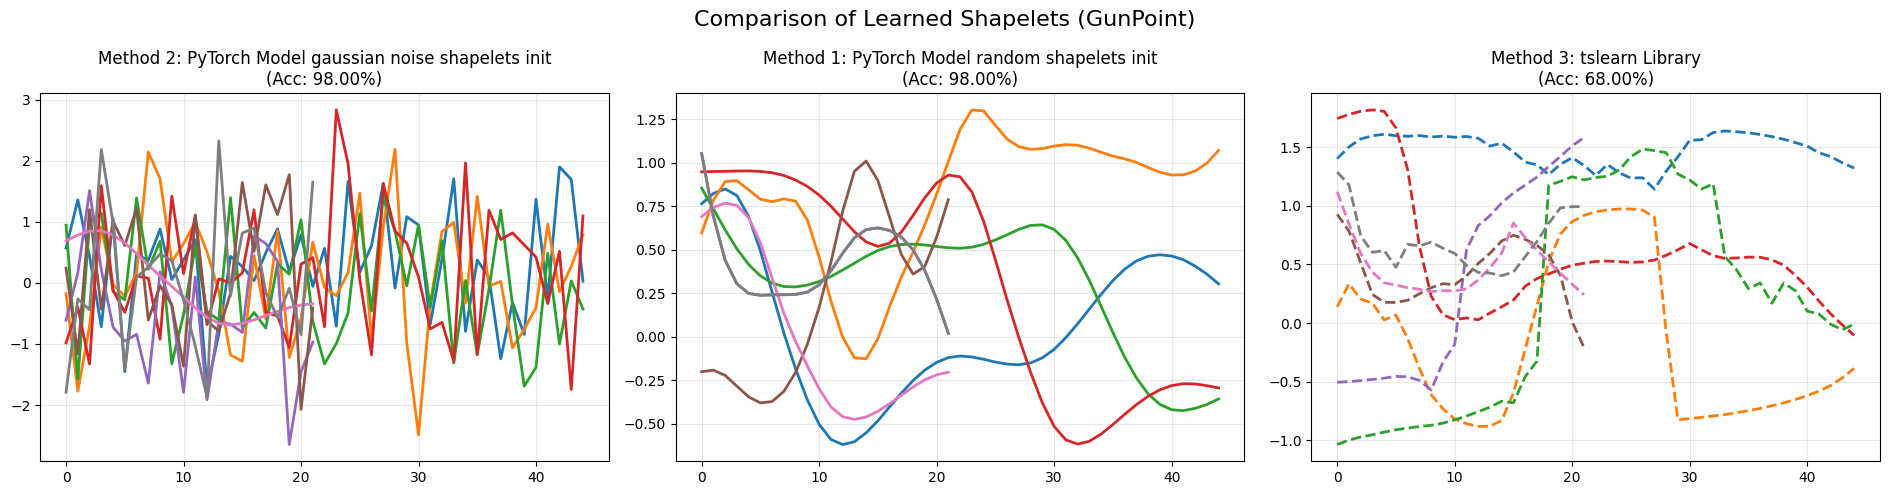

In [58]:
# -----------------------------------------------------------------------------
# VISUALIZATION & COMPARISON
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(19, 5))

# Plot PyTorch
flat_shapelets_list = []
if isinstance(pt_shapelets, list):
    for block in pt_shapelets:
        # block is (N_sub, Length) -> iterate to get individual (Length,) arrays
        for shp in block:
            flat_shapelets_list.append(shp)
else:
    # Fallback for old single-block models
    flat_shapelets_list = list(pt_shapelets)

# 2. Convert to a single numpy array (dtype=object for jagged arrays)
pt_shapelets_concat = np.array(flat_shapelets_list, dtype=object)


# Plot PyTorch
flat_shapelets_list_noise = []
if isinstance(pt_shapelets_noise, list):
    for block in pt_shapelets_noise:
        # block is (N_sub, Length) -> iterate to get individual (Length,) arrays
        for shp in block:
            flat_shapelets_list_noise.append(shp)
else:
    # Fallback for old single-block models
    flat_shapelets_list_noise = list(pt_shapelets_noise)

# 2. Convert to a single numpy array (dtype=object for jagged arrays)
pt_shapelets_concat_noise = np.array(flat_shapelets_list_noise, dtype=object)

for i in range(len(pt_shapelets_concat)):
    # We access the i-th shapelet from the flat array
    axes[1].plot(pt_shapelets_concat[i], linewidth=2, label=f'Shp {i+1}')
axes[1].set_title(f'Method 1: PyTorch Model random shapelets init\n(Acc: {pt_acc:.2%})')
axes[1].grid(True, alpha=0.3)

for i in range(len(pt_shapelets_concat_noise)):
    # We access the i-th shapelet from the flat array
    axes[0].plot(pt_shapelets_concat_noise[i], linewidth=2, label=f'Shp {i+1}')
axes[0].set_title(f'Method 2: PyTorch Model gaussian noise shapelets init\n(Acc: {pt_acc:.2%})')
axes[0].grid(True, alpha=0.3)

# Plot tslearn
for i in range(len(ts_shapelets)):
    axes[2].plot(ts_shapelets[i], linewidth=2, linestyle='--', label=f'Shp {i+1}')
axes[2].set_title(f'Method 3: tslearn Library\n(Acc: {ts_acc:.2%})')
axes[2].grid(True, alpha=0.3)

plt.suptitle(f"Comparison of Learned Shapelets ({meta['dataset']})", fontsize=16)
plt.tight_layout()
plt.show()

### 4. Shapelet Interpretability

We visualize where specific learned shapelets "fire" (match) on the raw time series to verify they correspond to physical features (e.g., the hand recoil).

In [59]:
def plot_shapelet_on_series(series, shapelets_dict, shapelet_index=0, title="Shapelet Analysis"):
    """
    Plots the best matching position of a specific shapelet (by index) 
    for multiple methods (provided in shapelets_dict) on the same series.
    
    Args:
        series (array): The time series data (1D).
        shapelets_dict (dict): Keys are method names (str), Values are arrays of shapelets.
                               e.g., {'tslearn': all_ts_shapelets, 'pytorch': all_pt_shapelets}
        shapelet_index (int): Which shapelet from the array to visualize (default 0).
    """
    series = series.ravel()
    n_methods = len(shapelets_dict)
    
    # Create subplots: 1 row per method
    fig, axes = plt.subplots(n_methods, 1, figsize=(12, 4 * n_methods), sharex=True)
    
    # Handle single-method case (axes is not a list if n=1)
    if n_methods == 1:
        axes = [axes]
        
    fig.suptitle(f"{title} - Comparing Shapelet #{shapelet_index+1}", fontsize=16)

    # Iterate over each method in the dictionary
    for ax, (method_name, shapelet_set) in zip(axes, shapelets_dict.items()):
        
        # 1. Select the specific shapelet
        # Check if shapelet_set is 2D (K shapelets) or 1D (single shapelet)
        shapelet_set = np.array(shapelet_set)
        if isinstance(shapelet_set, (np.ndarray, list)):
            current_shapelet = shapelet_set[shapelet_index]
        else:
            current_shapelet = shapelet_set
            
        current_shapelet = current_shapelet.ravel()
        
        # 2. Find Best Match (Sliding Window)
        n_series = len(series)
        n_shapelet = len(current_shapelet)
        if n_shapelet > n_series:
            print(f"Warning: Shapelet ({n_shapelet}) longer than series ({n_series}) for {method_name}")
            continue

        distances = []
        # Calculate Euclidean distance at every possible start point
        for i in range(n_series - n_shapelet + 1):
            window = series[i : i + n_shapelet]
            dist = np.linalg.norm(window - current_shapelet)
            distances.append(dist)
            
        best_idx = np.argmin(distances)
        min_dist = distances[best_idx]
        
        # 3. Plotting
        # A. Plot full series
        ax.plot(series, color='black', alpha=0.5, linewidth=1, label="Time Series")
        
        # B. Plot the shapelet overlay
        t_range = np.arange(best_idx, best_idx + n_shapelet)
        ax.plot(t_range, current_shapelet, color='tab:red', linewidth=3, label=f"{method_name} Shapelet")
        
        # C. Highlight the matching window
        ax.axvspan(best_idx, best_idx + n_shapelet, color='tab:red', alpha=0.15)
        
        # Formatting
        ax.set_title(f"Method: {method_name} (Dist: {min_dist:.4f})")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("Amplitude")

    plt.xlabel("Time Step")
    plt.tight_layout()
    plt.show()


def plot_all_shapelets_grid(series, shapelets_dict, title="Shapelet Match Analysis"):
    """
    Plots a grid of matches: 
    - Rows: Different Methods (PyTorch, tslearn)
    - Cols: Individual Shapelets (1..K)
    """
    series = series.ravel()
    
    n_methods = len(shapelets_dict)
    # Determine K (number of shapelets) from the first method in the dict
    first_key = list(shapelets_dict.keys())[0]
    n_shapelets = shapelets_dict[first_key].shape[0]
    
    # Create Grid
    fig, axes = plt.subplots(n_methods, n_shapelets, 
                             figsize=(n_shapelets * 3, n_methods * 2.5), 
                             sharex=True, sharey=True)
    
    # Ensure axes is always 2D array [row, col] for consistent indexing
    if n_methods == 1 and n_shapelets == 1:
        axes = np.array([[axes]])
    elif n_methods == 1:
        axes = axes[np.newaxis, :] # 1 row, multiple cols
    elif n_shapelets == 1:
        axes = axes[:, np.newaxis] # Multiple rows, 1 col
        
    fig.suptitle(f"{title}\n(Red Region = Best Match Location)", fontsize=16, y=1.02)

    # Iterate Rows (Methods)
    for row_idx, (method_name, shapelets) in enumerate(shapelets_dict.items()):
        
        # Iterate Cols (Individual Shapelets)
        for col_idx in range(n_shapelets):
            ax = axes[row_idx, col_idx]
            shapelet = shapelets[col_idx].ravel()
            
            # --- 1. Find Best Match Logic ---
            n_series = len(series)
            n_shp = len(shapelet)
            
            distances = []
            for i in range(n_series - n_shp + 1):
                window = series[i : i + n_shp]
                dist = np.linalg.norm(window - shapelet)
                distances.append(dist)
            
            if len(distances) > 0:
                best_idx = np.argmin(distances)
            else:
                best_idx = 0

            # --- 2. Plotting ---
            # Grey background series
            ax.plot(series, color='gray', alpha=0.3, linewidth=1)
            
            # Red shapelet overlay
            t_range = np.arange(best_idx, best_idx + n_shp)
            ax.plot(t_range, shapelet, color='red', linewidth=2)
            
            # ADDED: Vertical Span Highlight
            ax.axvspan(best_idx, best_idx + n_shp, color='red', alpha=0.1)
            
            # Visuals
            if col_idx == 0:
                ax.set_ylabel(f"{method_name}", fontsize=12, fontweight='bold')
            
            if row_idx == 0:
                ax.set_title(f"Shapelet {col_idx+1}", fontsize=10)
                
            ax.grid(True, alpha=0.1)

    plt.tight_layout()
    plt.show()

#### Execution

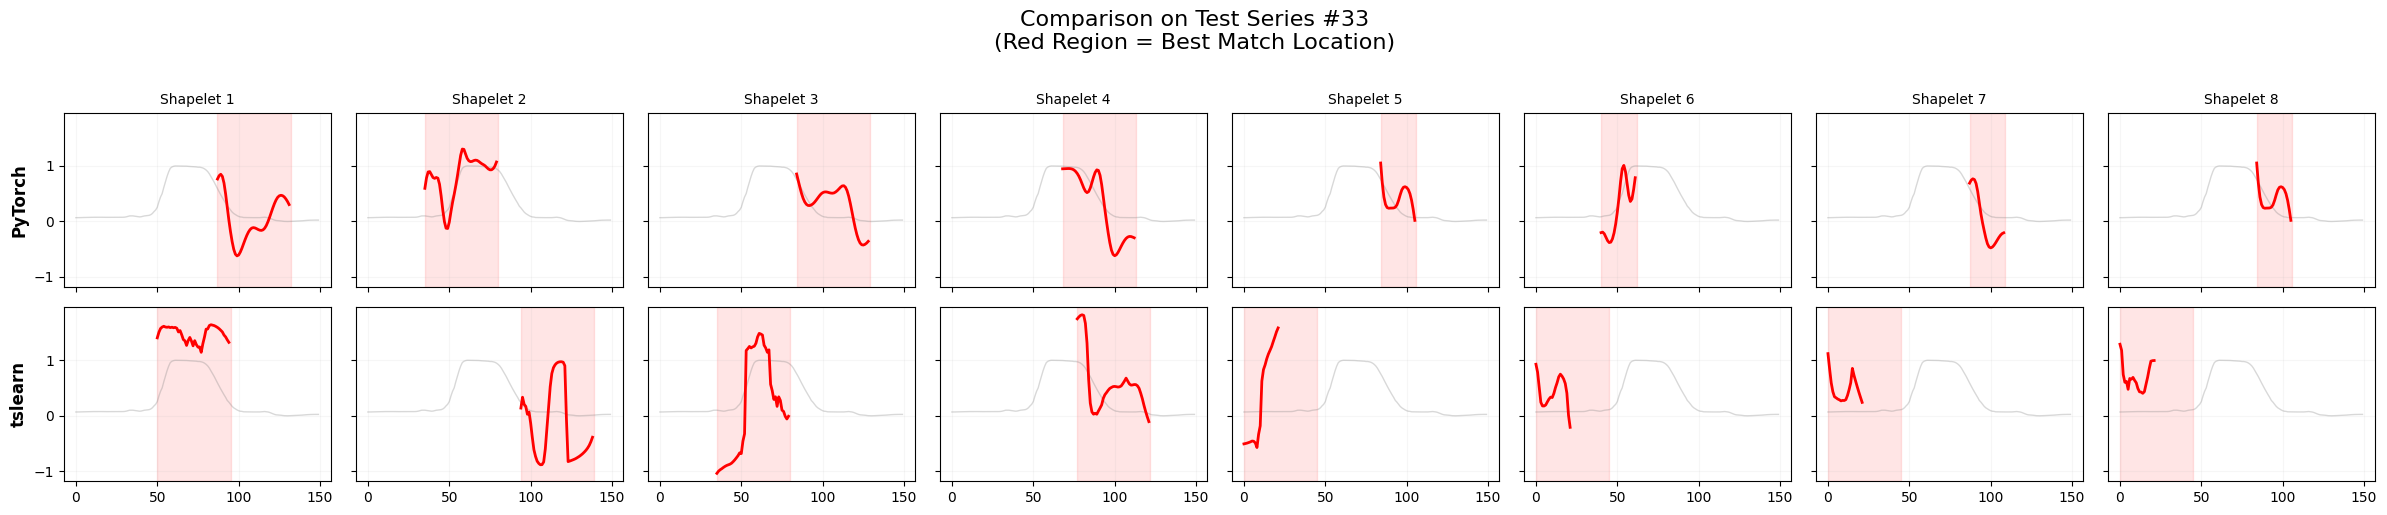

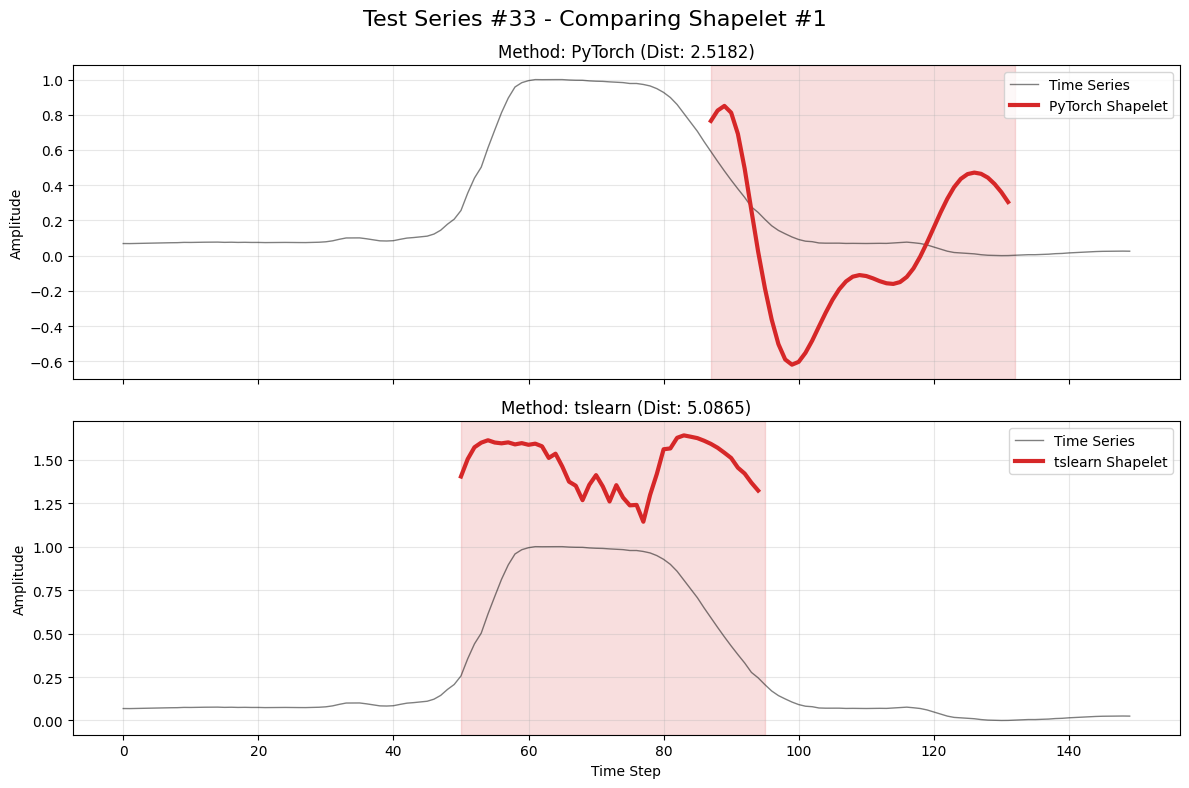

In [60]:
# Pick a random test series
sample_id = np.random.randint(0, X_test.shape[0])
series_data = X_test[sample_id]

# Define dictionary
shapelets_dict = {
    'PyTorch': pt_shapelets_concat, # Shape: (K, L)
    'tslearn': ts_shapelets  # Shape: (K, L)
}

plot_all_shapelets_grid(series_data, shapelets_dict, title=f"Comparison on Test Series #{sample_id}")


# Visualize Shapelet at index 0 (First shapelet) for both models
plot_shapelet_on_series(series_data, shapelets_dict, shapelet_index=0, title=f"Test Series #{sample_id}")

## Part D: Diagnostics & Sensitivity Analysis

Here we perform rigorous Grid Searches to validate our architectural choices. We analyze the "Vanishing Gradient" problem and the stability of the model under varying hyperparameters.

### Experiment 1: The Impact of Alpha (α)

We sweep α from −1 to −500.

Hypothesis: A "Goldilocks zone" exists around −100. Low α results in blurry averages; extremely high α causes gradient instability.

Running Alpha Sensitivity Analysis...
Testing Alpha = -1.0...
Training PyTorch Model (AdamW) for 2500 iterations...
Config: {45: 4} (Total K=4)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.7013
Iter 100: Loss = 0.6572
Iter 200: Loss = 0.4573
Iter 300: Loss = 0.3637
Iter 400: Loss = 0.3227
Iter 500: Loss = 0.2995
Iter 600: Loss = 0.2835
Iter 700: Loss = 0.2710
Iter 800: Loss = 0.2609
Iter 900: Loss = 0.2517
Iter 1000: Loss = 0.2433
Iter 1100: Loss = 0.2361
Iter 1200: Loss = 0.2291
Iter 1300: Loss = 0.2232
Iter 1400: Loss = 0.2176
Iter 1500: Loss = 0.2130
Iter 1600: Loss = 0.2086
Iter 1700: Loss = 0.2050
Iter 1800: Loss = 0.2017
Iter 1900: Loss = 0.1988
Iter 2000: Loss = 0.1961
Iter 2100: Loss = 0.1936
Iter 2200: Loss = 0.1914
Iter 2300: Loss = 0.1893
Iter 2400: Loss = 0.1874
Training Complete.
Testing Alpha = -2.0...
Training PyTorch Model (AdamW) for 2500 iterations...
Co

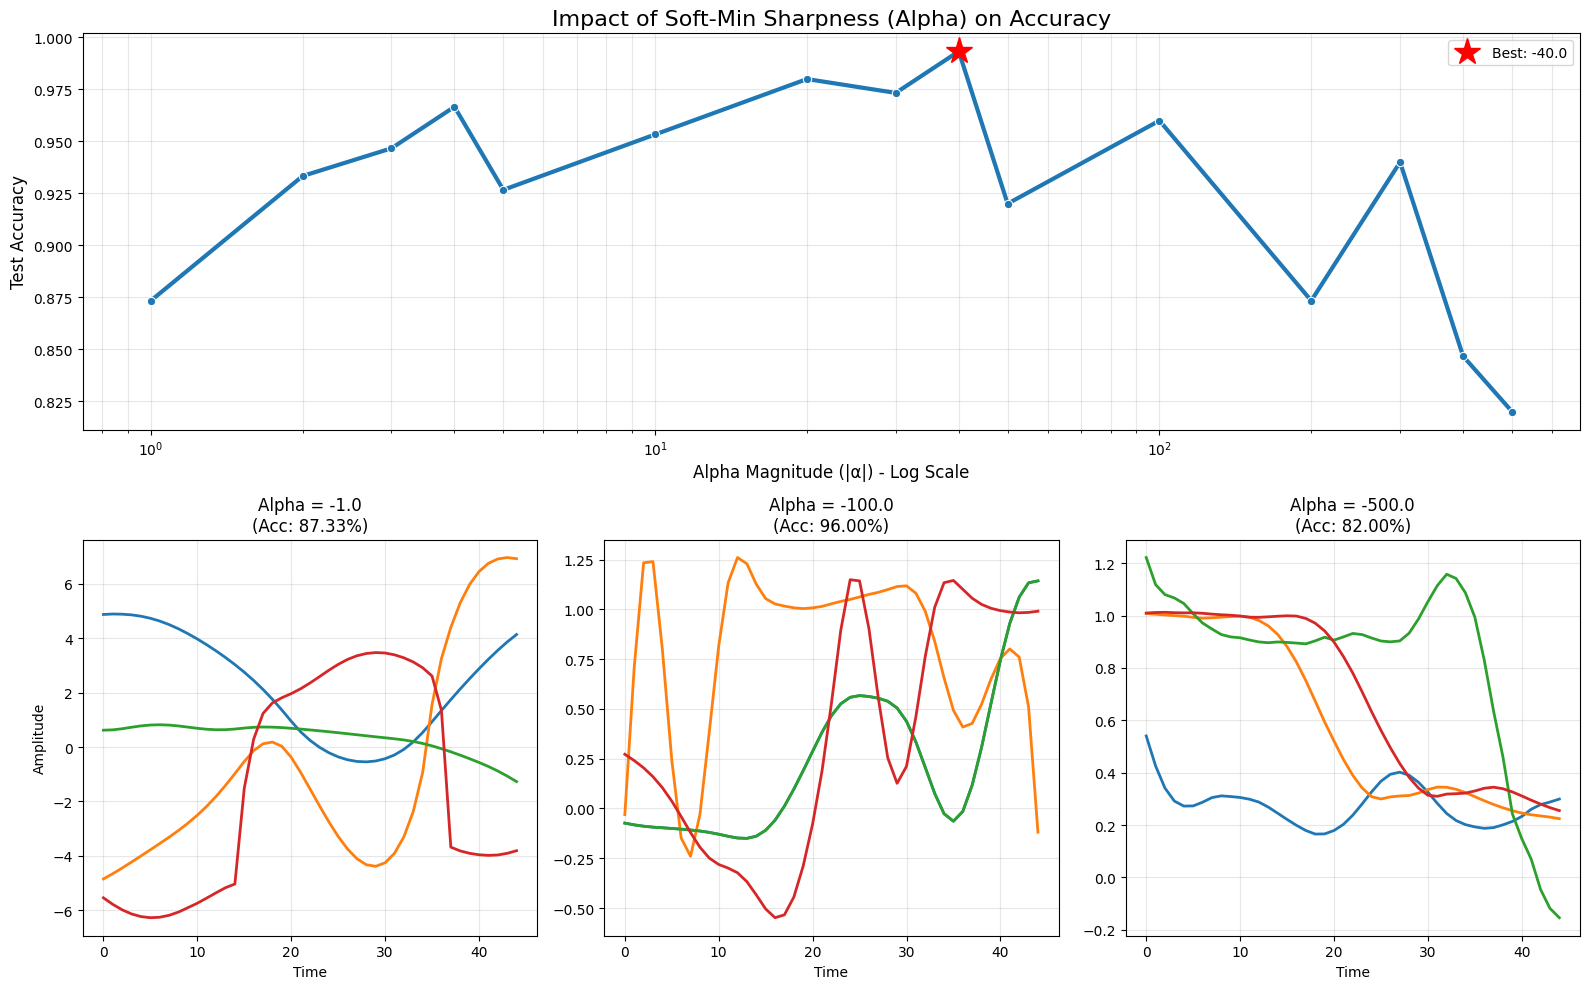

In [61]:
# -----------------------------------------------------------------------------
# EXPERIMENT 1: ALPHA SENSITIVITY
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 1. SETUP THE EXPERIMENT
# -----------------------------------------------------------------------------
# We fix everything else and only vary Alpha
param_grid = {
    'ITERATIONS': [2500],            # Fixed
    'OPTIMIZER_NAME': ['AdamW'],    # Fixed
    'LR': [0.01],                   # Fixed
    'LAMBDA_W': [0.01],             # Fixed
    'INIT_MODE': ['random'],        # Fixed
    'shapelets_dict': [{45: 4}],    # Fixed config (e.g., 4 shapelets of len 30)
    
    # THE VARIABLE OF INTEREST
    # We span from very soft (-1) to very hard (-500)
    'ALPHA': [-1.0, -2.0, -3.0, -4.0, -5.0, -10.0, -20.0, -30.0, -40.0, -50.0, -100.0, -200.0, -300.0, -400.0, -500.0] 
}

# -----------------------------------------------------------------------------
# 2. RUN SEARCH (Modified to save all shapelets)
# -----------------------------------------------------------------------------
print("Running Alpha Sensitivity Analysis...")
grid_results = []

# Manual loop to ensure we keep the shapelets for plotting
for alpha in param_grid['ALPHA']:
    # Construct config for this run
    config = {
        'meta': meta,
        'ITERATIONS': param_grid['ITERATIONS'][0],
        'OPTIMIZER_NAME': param_grid['OPTIMIZER_NAME'][0],
        'LR': param_grid['LR'][0],
        'LAMBDA_W': param_grid['LAMBDA_W'][0],
        'INIT_MODE': param_grid['INIT_MODE'][0],
        'shapelets_dict': param_grid['shapelets_dict'][0],
        'ALPHA': alpha
    }
    
    print(f"Testing Alpha = {alpha}...")
    
    # Train
    run_out = pt_model_training(X_train, y_train, config)
    pt_model = run_out['model']
    
    # Evaluate
    pt_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.squeeze(), dtype=torch.float32)
        if X_test_tensor.ndim == 1: X_test_tensor = X_test_tensor.unsqueeze(1)
        
        logits, _ = pt_model(X_test_tensor)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == torch.tensor(y_test, dtype=torch.long)).sum().item() / len(y_test)
    
    # Flatten shapelets for storage
    flat_shp = []
    for block in run_out['shapelets']:
        for shp in block:
            flat_shp.append(shp)
            
    grid_results.append({
        'alpha': alpha,
        'accuracy': acc,
        'shapelets': np.array(flat_shp, dtype=object)
    })

# Convert to DataFrame for easier plotting of metrics
df_alpha = pd.DataFrame(grid_results)

# -----------------------------------------------------------------------------
# 3. VISUALIZATION
# -----------------------------------------------------------------------------
df_alpha['alpha_abs'] = df_alpha['alpha'].abs()

# ... setup figure ...
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3)
ax_acc = fig.add_subplot(gs[0, :])

# 2. CHANGE X to 'alpha_abs' (the positive version)
sns.lineplot(data=df_alpha, x='alpha_abs', y='accuracy', marker='o', linewidth=3, ax=ax_acc, color='tab:blue')

ax_acc.set_title(f"Impact of Soft-Min Sharpness (Alpha) on Accuracy", fontsize=16)
ax_acc.set_ylabel("Test Accuracy", fontsize=12)

# 3. Log Scale now works because x is positive
ax_acc.set_xscale('log')
ax_acc.set_xlabel("Alpha Magnitude (|α|) - Log Scale", fontsize=12)
ax_acc.grid(True, which="both", alpha=0.3)

# 4. Fix the "Best Point" plotting to match the new X-axis
best_row = df_alpha.loc[df_alpha['accuracy'].idxmax()]
# Use best_row['alpha_abs'] for X, not best_row['alpha']
ax_acc.plot(best_row['alpha_abs'], best_row['accuracy'], 'r*', markersize=20, label=f"Best: {best_row['alpha']}")

ax_acc.legend()

# --- PLOT B: SHAPELET COMPARISONS ---
# We pick 3 representative runs to plot: Low, Medium, High magnitude
alpha_samples = [param_grid['ALPHA'][0], -100.0, param_grid['ALPHA'][-1]] 
# e.g., -1, -100, -500

# Subplot locations for the bottom row
subplots_locs = [gs[1, 0], gs[1, 1], gs[1, 2]]

for i, target_alpha in enumerate(alpha_samples):
    # Find the result for this alpha
    row = df_alpha[df_alpha['alpha'] == target_alpha].iloc[0]
    shapelets = row['shapelets']
    acc = row['accuracy']
    
    ax = fig.add_subplot(subplots_locs[i])
    for j, shp in enumerate(shapelets):
        ax.plot(shp, linewidth=2, label=f'Shp {j+1}')
        
    ax.set_title(f"Alpha = {target_alpha}\n(Acc: {acc:.2%})")
    ax.grid(True, alpha=0.3)
    if i == 0: ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()

### Experiment 2: Learning Rate Sensitivity

We analyze the behavior of AdamW across logarithmic scales of Learning Rate.

Hypothesis: Extremely high LR will cause artifacting (square waves), while low LR results in underfitting.

Running Learning Rate Sensitivity Analysis...
Training PyTorch Model (AdamW) for 2500 iterations...
Config: {45: 4} (Total K=4)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.7744
Iter 100: Loss = 0.7690
Iter 200: Loss = 0.7638
Iter 300: Loss = 0.7587
Iter 400: Loss = 0.7537
Iter 500: Loss = 0.7489
Iter 600: Loss = 0.7441
Iter 700: Loss = 0.7394
Iter 800: Loss = 0.7347
Iter 900: Loss = 0.7300
Iter 1000: Loss = 0.7253
Iter 1100: Loss = 0.7206
Iter 1200: Loss = 0.7160
Iter 1300: Loss = 0.7114
Iter 1400: Loss = 0.7066
Iter 1500: Loss = 0.7018
Iter 1600: Loss = 0.6975
Iter 1700: Loss = 0.6933
Iter 1800: Loss = 0.6894
Iter 1900: Loss = 0.6857
Iter 2000: Loss = 0.6822
Iter 2100: Loss = 0.6788
Iter 2200: Loss = 0.6756
Iter 2300: Loss = 0.6726
Iter 2400: Loss = 0.6697
Training Complete.
Training PyTorch Model (AdamW) for 2500 iterations...
Config: {45: 4} (Total K=4)
Initialization

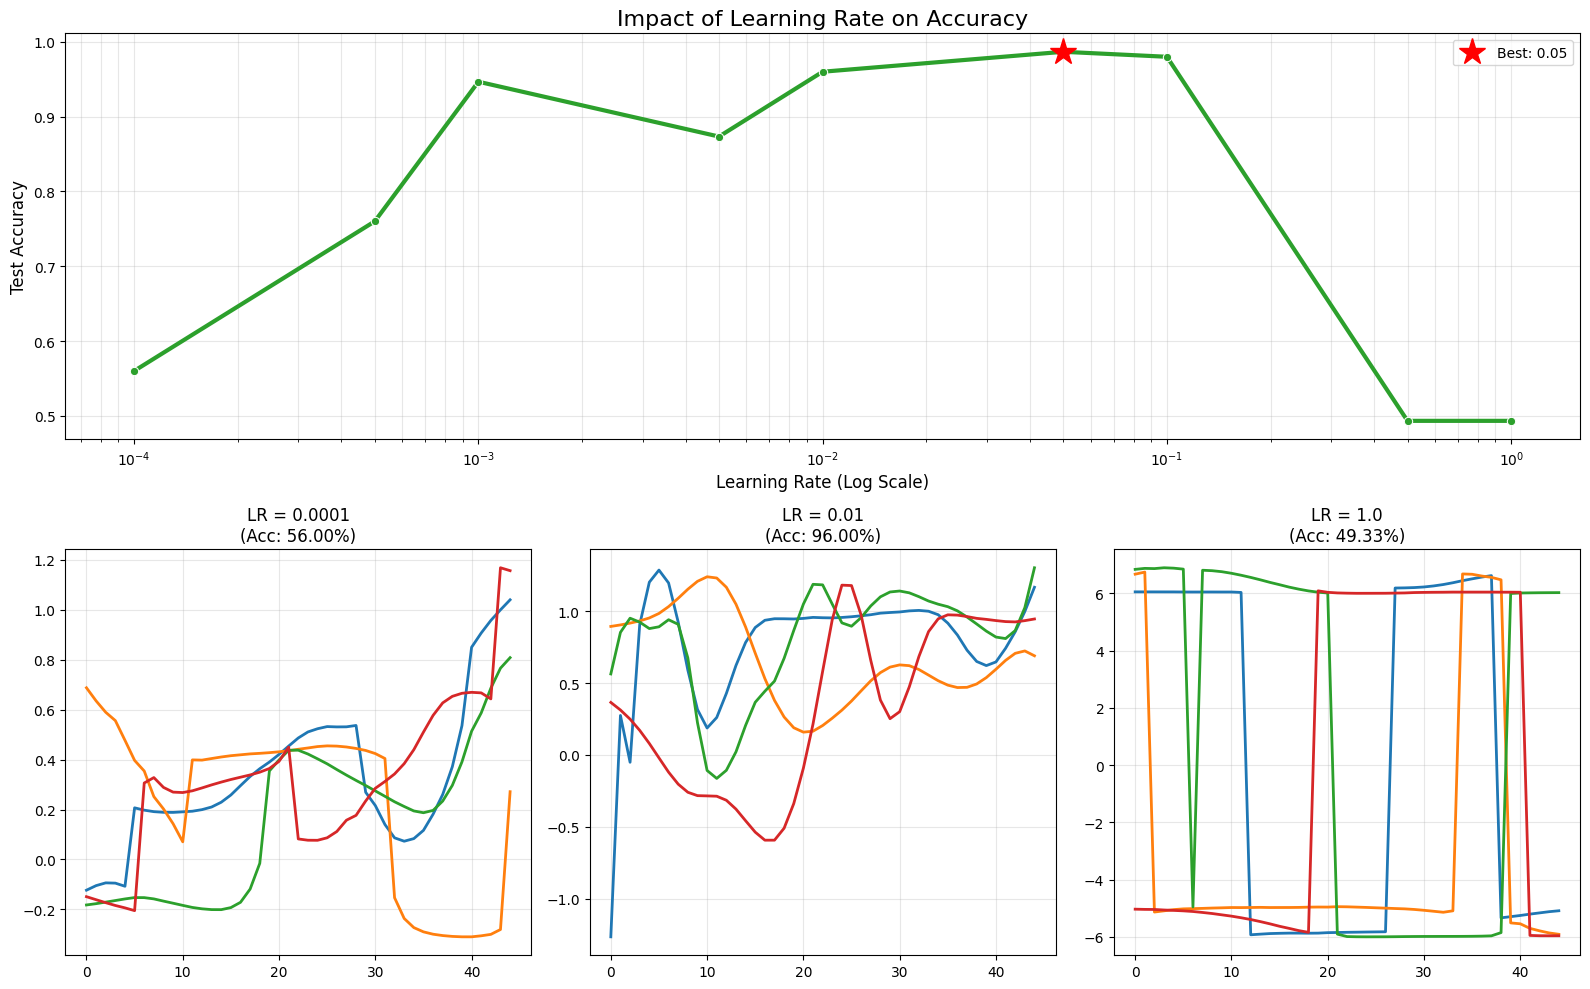

In [62]:
# -----------------------------------------------------------------------------
# EXPERIMENT 2: LEARNING RATE SENSITIVITY
# -----------------------------------------------------------------------------
# Fix Alpha to your best value (e.g., -100 or -40)
BEST_ALPHA = -100.0 

param_grid_lr = {
    'ITERATIONS': [2500],
    'OPTIMIZER_NAME': ['AdamW'],
    'LAMBDA_W': [0.01],         # Fixed
    'INIT_MODE': ['random'],    # Fixed
    'shapelets_dict': [{45: 4}], 
    'ALPHA': [BEST_ALPHA],      # Fixed
    
    # VARIABLE: Learning Rate (Log scale sweep)
    'LR': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
}

print("Running Learning Rate Sensitivity Analysis...")
lr_results = []

for lr in param_grid_lr['LR']:
    config = {
        'meta': meta,
        'ITERATIONS': param_grid_lr['ITERATIONS'][0],
        'OPTIMIZER_NAME': param_grid_lr['OPTIMIZER_NAME'][0],
        'LAMBDA_W': param_grid_lr['LAMBDA_W'][0],
        'INIT_MODE': param_grid_lr['INIT_MODE'][0],
        'shapelets_dict': param_grid_lr['shapelets_dict'][0],
        'ALPHA': param_grid_lr['ALPHA'][0],
        'LR': lr
    }
    
    # Train
    run_out = pt_model_training(X_train, y_train, config)
    pt_model = run_out['model']
    
    # Evaluate
    pt_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.squeeze(), dtype=torch.float32)
        if X_test_tensor.ndim == 1: X_test_tensor = X_test_tensor.unsqueeze(1)
        logits, _ = pt_model(X_test_tensor)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == torch.tensor(y_test, dtype=torch.long)).sum().item() / len(y_test)
    
    # Store
    flat_shp = []
    for block in run_out['shapelets']:
        for shp in block:
            flat_shp.append(shp)
            
    lr_results.append({
        'lr': lr,
        'accuracy': acc,
        'shapelets': np.array(flat_shp, dtype=object)
    })

df_lr = pd.DataFrame(lr_results)

# --- VISUALIZATION (LR) ---
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3)

# 1. Accuracy Plot
ax_acc = fig.add_subplot(gs[0, :])
sns.lineplot(data=df_lr, x='lr', y='accuracy', marker='o', linewidth=3, ax=ax_acc, color='tab:green')
ax_acc.set_xscale('log') # Log scale is crucial for LR
ax_acc.set_title("Impact of Learning Rate on Accuracy", fontsize=16)
ax_acc.set_xlabel("Learning Rate (Log Scale)", fontsize=12)
ax_acc.set_ylabel("Test Accuracy", fontsize=12)
ax_acc.grid(True, which="both", alpha=0.3)

# Mark Best
best_row = df_lr.loc[df_lr['accuracy'].idxmax()]
ax_acc.plot(best_row['lr'], best_row['accuracy'], 'r*', markersize=20, label=f"Best: {best_row['lr']}")
ax_acc.legend()

# 2. Shapelet Comparison (Low, Medium, High)
# Pick 3 indices: First (Low), Middle (Opt), Last (High)
indices = [0, len(df_lr)//2, -1] 
subplots = [gs[1, 0], gs[1, 1], gs[1, 2]]

for i, idx in enumerate(indices):
    row = df_lr.iloc[idx]
    ax = fig.add_subplot(subplots[i])
    for j, shp in enumerate(row['shapelets']):
        ax.plot(shp, linewidth=2, label=f'Shp {j+1}')
    ax.set_title(f"LR = {row['lr']}\n(Acc: {row['accuracy']:.2%})")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Experiment 3: Regularization (λ_W)

We test our Selective Weight Decay strategy.

Hypothesis: We expect accuracy to remain stable even with moderate regularization because we are not penalizing the shapelet weights, only the classifier. Accuracy should only collapse when the classifier is completely suppressed (λ>0.1).

Running Lambda_W Sensitivity Analysis...
Training PyTorch Model (AdamW) for 1000 iterations...
Config: {45: 4} (Total K=4)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.7270
Iter 100: Loss = 0.5727
Iter 200: Loss = 0.4075
Iter 300: Loss = 0.3096
Iter 400: Loss = 0.2591
Iter 500: Loss = 0.2248
Iter 600: Loss = 0.1989
Iter 700: Loss = 0.1719
Iter 800: Loss = 0.1504
Iter 900: Loss = 0.1357
Training Complete.
Training PyTorch Model (AdamW) for 1000 iterations...
Config: {45: 4} (Total K=4)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GunPoint...
Iter 0: Loss = 0.6945
Iter 100: Loss = 0.5836
Iter 200: Loss = 0.4129
Iter 300: Loss = 0.3233
Iter 400: Loss = 0.2714
Iter 500: Loss = 0.2349
Iter 600: Loss = 0.2072
Iter 700: Loss = 0.1852
Iter 800: Loss = 0.1672
Iter 900: Loss = 0.1521
Training Com

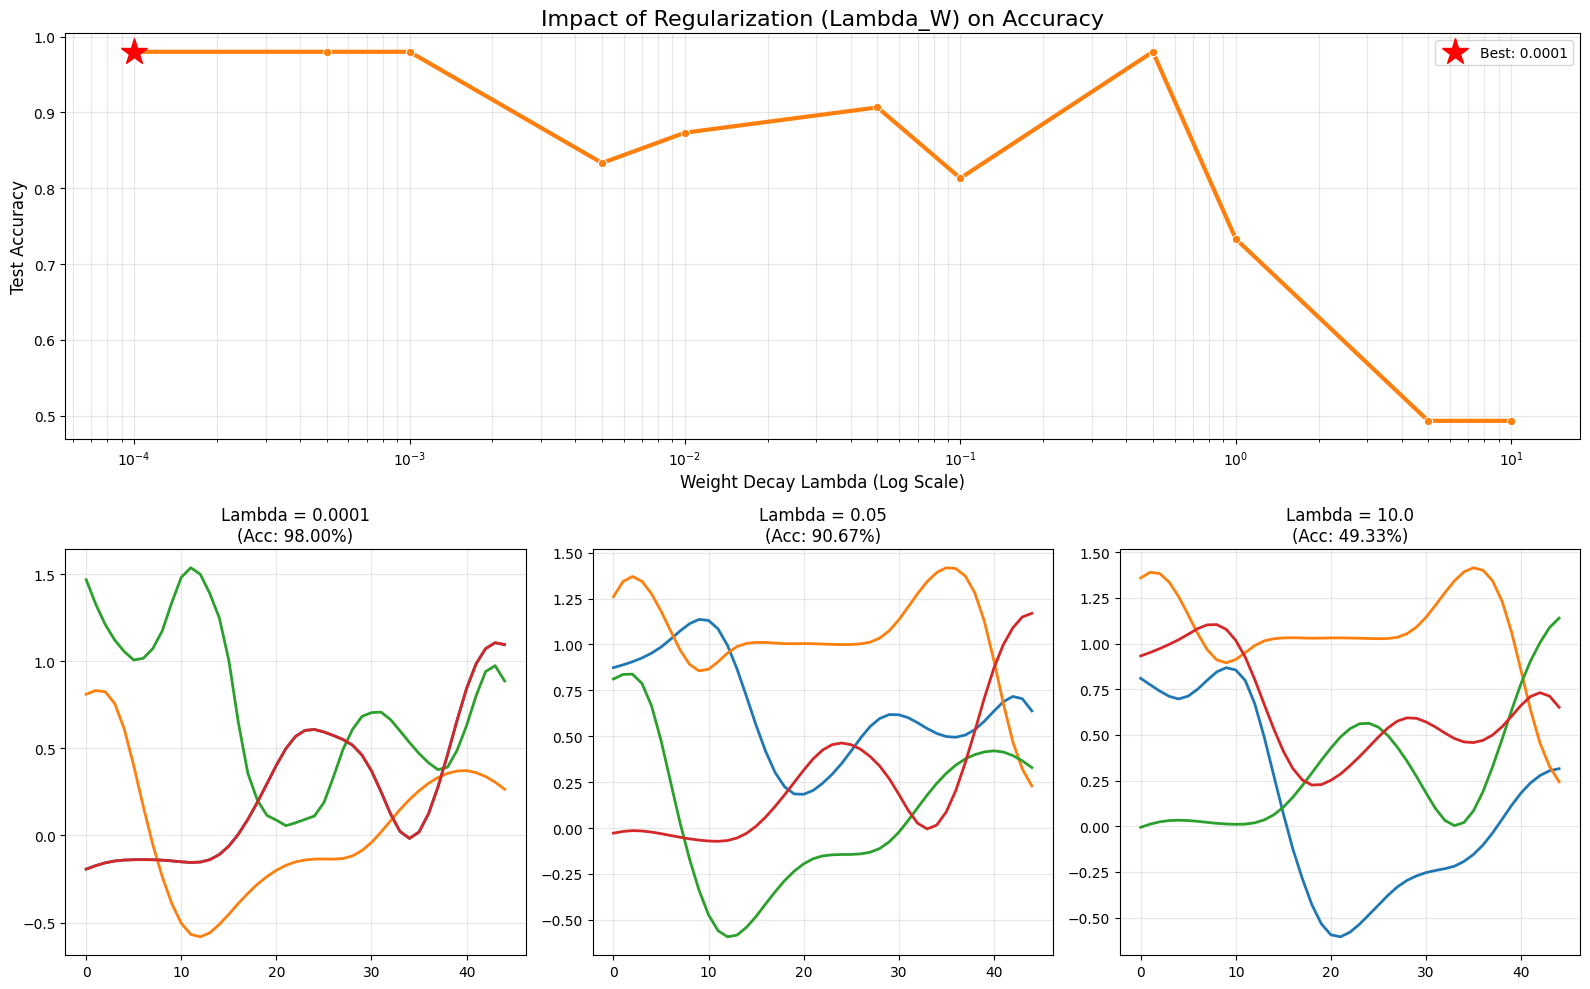

In [63]:
# -----------------------------------------------------------------------------
# EXPERIMENT 3: REGULARIZATION (LAMBDA_W) SENSITIVITY
# -----------------------------------------------------------------------------
BEST_LR = 0.01
param_grid_reg = {
    'ITERATIONS': [1000],
    'OPTIMIZER_NAME': ['AdamW'],
    'LR': [BEST_LR],               # Fixed
    'INIT_MODE': ['random'],    # Fixed
    'shapelets_dict': [{45: 4}], 
    'ALPHA': [BEST_ALPHA],      # Fixed
    
    # VARIABLE: Lambda (Log scale sweep, including 0.0)
    'LAMBDA_W': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
}

print("Running Lambda_W Sensitivity Analysis...")
reg_results = []

for lam in param_grid_reg['LAMBDA_W']:
    config = {
        'meta': meta,
        'ITERATIONS': param_grid_reg['ITERATIONS'][0],
        'OPTIMIZER_NAME': param_grid_reg['OPTIMIZER_NAME'][0],
        'LR': param_grid_reg['LR'][0],
        'INIT_MODE': param_grid_reg['INIT_MODE'][0],
        'shapelets_dict': param_grid_reg['shapelets_dict'][0],
        'ALPHA': param_grid_reg['ALPHA'][0],
        'LAMBDA_W': lam
    }
    
    # Train
    run_out = pt_model_training(X_train, y_train, config)
    pt_model = run_out['model']
    
    # Evaluate
    pt_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.squeeze(), dtype=torch.float32)
        if X_test_tensor.ndim == 1: X_test_tensor = X_test_tensor.unsqueeze(1)
        logits, _ = pt_model(X_test_tensor)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == torch.tensor(y_test, dtype=torch.long)).sum().item() / len(y_test)
    
    # Store
    flat_shp = []
    for block in run_out['shapelets']:
        for shp in block:
            flat_shp.append(shp)
            
    reg_results.append({
        'lambda': lam,
        'accuracy': acc,
        'shapelets': np.array(flat_shp, dtype=object)
    })

df_reg = pd.DataFrame(reg_results)

# --- VISUALIZATION (Lambda) ---
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3)

# 1. Accuracy Plot
ax_acc = fig.add_subplot(gs[0, :])
# Handle 0.0 for log scale plotting by replacing it with a tiny number or just ignoring log for 0
df_plot = df_reg.copy()
df_plot.loc[df_plot['lambda'] == 0.0, 'lambda'] = 0.00001 # Small epsilon for plot

sns.lineplot(data=df_plot, x='lambda', y='accuracy', marker='o', linewidth=3, ax=ax_acc, color='tab:orange')
ax_acc.set_xscale('log')
ax_acc.set_title("Impact of Regularization (Lambda_W) on Accuracy", fontsize=16)
ax_acc.set_xlabel("Weight Decay Lambda (Log Scale)", fontsize=12)
ax_acc.set_ylabel("Test Accuracy", fontsize=12)
ax_acc.grid(True, which="both", alpha=0.3)

# Mark Best
best_row = df_reg.loc[df_reg['accuracy'].idxmax()]
best_val_plot = 0.00001 if best_row['lambda'] == 0.0 else best_row['lambda']
ax_acc.plot(best_val_plot, best_row['accuracy'], 'r*', markersize=20, label=f"Best: {best_row['lambda']}")
ax_acc.legend()

# 2. Shapelet Comparison
# Indices: 0 (No Reg), Middle (Moderate), Last (High Reg)
indices = [0, len(df_reg)//2, -1]
subplots = [gs[1, 0], gs[1, 1], gs[1, 2]]

for i, idx in enumerate(indices):
    row = df_reg.iloc[idx]
    ax = fig.add_subplot(subplots[i])
    for j, shp in enumerate(row['shapelets']):
        ax.plot(shp, linewidth=2, label=f'Shp {j+1}')
    ax.set_title(f"Lambda = {row['lambda']}\n(Acc: {row['accuracy']:.2%})")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part E: Multiclass Generalization (ElectricDevices)

To prove the robustness of the model, we move beyond simple binary classification to a complex dataset: ElectricDevices (7 classes).

This dataset characterizes electricity consumption profiles of various household appliances, featuring high intra-class variability and sharp, high-frequency signatures.

### 1. Data Loading & Visualization

Loading the 7-class dataset and visualizing the distinct "on/off" switching pattern

In [64]:
# -----------------------------------------------------------------------------
# DATA LOADING & PREPROCESSING
# -----------------------------------------------------------------------------

# Load Complex Dataset (e.g., ElectricDevices: 7 classes)
# Or "Trace" (4 classes), "Plane" (7 classes)
target_dataset = "ElectricDevices" 
print(f"Loading {target_dataset}...")

ucr = UCR_UEA_datasets()
try:
    X_train, y_train, X_test, y_test = ucr.load_dataset(target_dataset)
except:
    print("Download failed, falling back to cached GunPoint for demo...")
    X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")

# Preprocessing
sc = TimeSeriesScalerMinMax()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Label Encoding (Ensure 0..C-1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(f"Data Loaded: Train={X_train.shape}, Test={X_test.shape}")
print(f"Classes: {len(np.unique(y_train))}")


Loading ElectricDevices...
Data Loaded: Train=(8926, 96, 1), Test=(7711, 96, 1)
Classes: 7


In [69]:
def plot_dataset_samples(X, y, num_samples=3, title="Time Series Samples by Class"):
    """
    Plots a few random samples from each class in a 3-column grid.
    """
    classes = np.unique(y)
    n_classes = len(classes)

    n_cols = 3
    n_rows = int(np.ceil(n_classes / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(18, 3 * n_rows),  # wider to fit 3 columns
        sharex=True,
        sharey=False
    )

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        idxs = np.where(y == cls)[0]
        selected_idxs = np.random.choice(
            idxs, min(num_samples, len(idxs)), replace=False
        )

        ax = axes[i]
        for idx in selected_idxs:
            series = X[idx].ravel()
            ax.plot(series, alpha=0.7, linewidth=1.5)

        ax.set_title(f"Class {cls+1} (n={len(idxs)})")
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("Amplitude")
        ax.set_xlabel("Time Step")

    # Hide any unused subplots
    for j in range(n_classes, len(axes)):
        axes[j].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


#### Visualization

Plotting samples for dataset: ElectricDevices


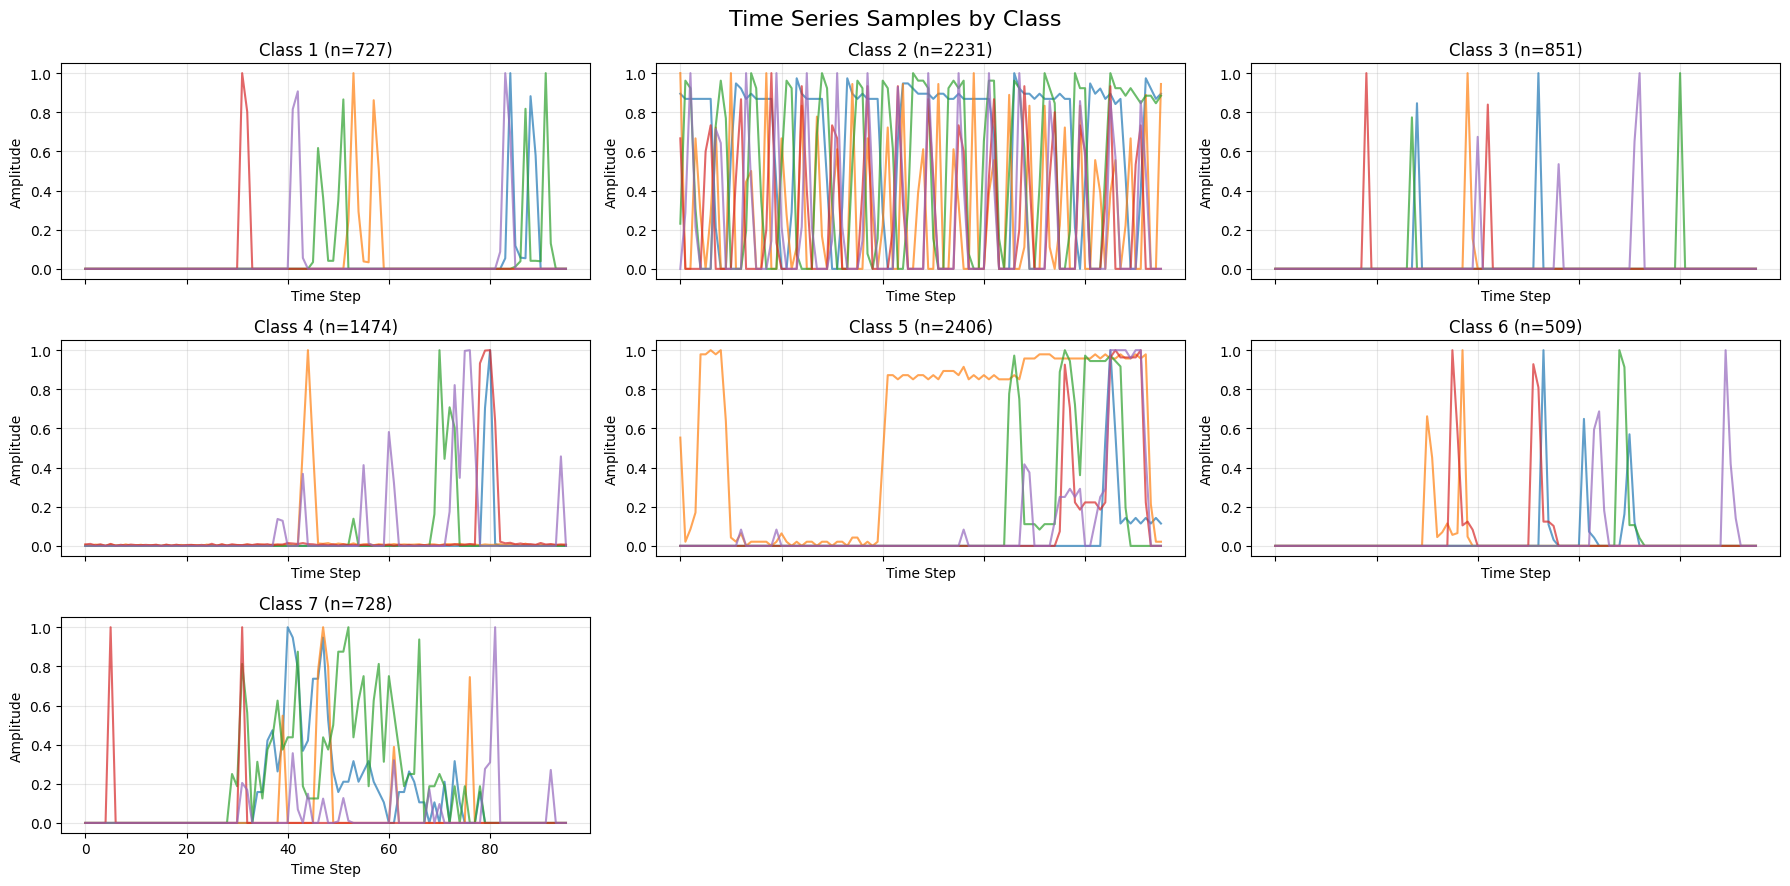

In [70]:
print(f"Plotting samples for dataset: {target_dataset}")
plot_dataset_samples(X_train, y_train, num_samples=5)

### 2. Baselines (1NN-DTW & Euclidean)

We calculate standard baselines using tslearn. 1NN-DTW is generally considered a strong benchmark for time series classification.

In [67]:
# -----------------------------------------------------------------------------
# BASELINES (Your Code)
# -----------------------------------------------------------------------------
def fit_baselines_once(X_train, y_train, X_test, y_test):
    print("=== Baselines (fit once) ===")

    # Subsample for baselines if dataset is huge (DTW is O(N^2))
    if len(X_train) > 2000:
        print("Note: Subsampling baselines to 2000 samples for speed...")
        idx = np.random.choice(len(X_train), 2000, replace=False)
        X_train_sub, y_train_sub = X_train[idx], y_train[idx]
    else:
        X_train_sub, y_train_sub = X_train, y_train

    knn_euc = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="euclidean")
    # knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")

    print("-> Fitting 1NN-Euclidean...")
    t0 = time.perf_counter()
    knn_euc.fit(X_train_sub, y_train_sub)
    fit_euc_s = time.perf_counter() - t0

    # print("-> Fitting 1NN-DTW (this might take a while)...")
    # t0 = time.perf_counter()
    # knn_dtw.fit(X_train_sub, y_train_sub)
    # fit_dtw_s = time.perf_counter() - t0

    print("-> Predicting Euclidean...")
    t0 = time.perf_counter()
    pred_euc = knn_euc.predict(X_test)
    pred_euc_s = time.perf_counter() - t0

    # print("-> Predicting DTW...")
    # t0 = time.perf_counter()
    # pred_dtw = knn_dtw.predict(X_test)
    # pred_dtw_s = time.perf_counter() - t0

    baselines = pd.DataFrame(
        [
            {
                "model": "1NN-euclidean",
                "test_acc": float(accuracy_score(y_test, pred_euc)),
                "test_bal_acc": float(balanced_accuracy_score(y_test, pred_euc)),
                "test_f1_macro": float(f1_score(y_test, pred_euc, average="macro")),
                "total_time_s": fit_euc_s + pred_euc_s,
            },
            # {
            #     "model": "1NN-dtw",
            #     "test_acc": float(accuracy_score(y_test, pred_dtw)),
            #     "test_bal_acc": float(balanced_accuracy_score(y_test, pred_dtw)),
            #     "test_f1_macro": float(f1_score(y_test, pred_dtw, average="macro")),
            #     "total_time_s": fit_dtw_s + pred_dtw_s,
            # },
        ]
    ).sort_values("test_acc", ascending=False)

    print(baselines.to_string(index=False))
    print()

    return baselines

In [68]:
# Run Baselines
df_baselines = fit_baselines_once(X_train, y_train, X_test, y_test)

=== Baselines (fit once) ===
Note: Subsampling baselines to 2000 samples for speed...
-> Fitting 1NN-Euclidean...
-> Predicting Euclidean...
        model  test_acc  test_bal_acc  test_f1_macro  total_time_s
1NN-euclidean  0.467384      0.407994       0.404023      4.735113



### 3. PyTorch Grid Search

We run a grid search to find the optimal Shapelet configuration (Lengths and Counts) for this specific dataset.

In [69]:
# -----------------------------------------------------------------------------
# PYTORCH GRID SEARCH (Updated for Comparison)
# -----------------------------------------------------------------------------
def pt_grid_search_pipeline(X_train, y_train, X_test, y_test, param_grid):
    grid = ParameterGrid(param_grid)
    results_list = []
    best_acc = -1.0
    best_run = None
    
    print(f"=== PyTorch Grid Search ({len(grid)} combinations) ===")
    
    meta_info = {
        'dataset': 'GridSearch',
        'n_classes': len(np.unique(y_train)),
        'ts_len': X_train.shape[1]
    }

    for i, params in enumerate(grid):
        print(f"Run {i+1}/{len(grid)} | Params: {params}")
        
        train_config = params.copy()
        train_config['meta'] = meta_info
        
        try:
            # 1. Train
            run_output = pt_model_training(X_train, y_train, train_config)
            
            # 2. Evaluate
            pt_model = run_output['model']
            pt_model.eval()
            
            with torch.no_grad():
                X_test_sq = X_test.squeeze()
                if X_test_sq.ndim == 1: X_test_sq = X_test_sq.unsqueeze(1)
                X_test_tensor = torch.tensor(X_test_sq, dtype=torch.float32)
                y_test_tensor = torch.tensor(y_test, dtype=torch.long)
                
                logits, _ = pt_model(X_test_tensor)
                preds = torch.argmax(logits, dim=1)
                
                # Metrics
                acc = accuracy_score(y_test, preds.cpu().numpy())
                bal_acc = balanced_accuracy_score(y_test, preds.cpu().numpy())
                f1 = f1_score(y_test, preds.cpu().numpy(), average="macro")
            
            print(f"   -> Test Acc: {acc:.4%} | Time: {run_output['time']:.2f}s")
            
            # 3. Store Result
            result_entry = params.copy()
            result_entry['shapelets_dict_str'] = str(params['shapelets_dict']) 
            result_entry['test_acc'] = acc
            result_entry['test_bal_acc'] = bal_acc
            result_entry['test_f1_macro'] = f1
            result_entry['total_time_s'] = run_output['time'] # Approximation (Train time dominates)
            results_list.append(result_entry)
            
            # 4. Track Best
            if acc > best_acc:
                best_acc = acc
                flat_shapelets = []
                for block in run_output['shapelets']:
                    for shp in block:
                        flat_shapelets.append(shp)

                best_run = {
                    'params': params,
                    'model': pt_model,
                    'test_acc': acc,
                    'shapelets': np.array(flat_shapelets, dtype=object),
                    'time': run_output['time']
                }
                
        except Exception as e:
            print(f"   -> Run Failed: {e}")
            import traceback
            traceback.print_exc()
            
    print("="*60)
    print(f"Grid Search Complete. Best Accuracy: {best_acc:.4%}")
    
    return pd.DataFrame(results_list), best_run


In [ ]:
# Run PyTorch Grid Search
# Fixing Lambda_W to 0.01, varying Shapelets and LR
ts_len = X_train.shape[1]

param_grid = {
    'ITERATIONS': [2000],
    'OPTIMIZER_NAME': ['AdamW'], 
    'LAMBDA_W': [0.01],           # Fixed as requested
    'ALPHA': [-100.0],            # Fixed sweet spot
    'INIT_MODE': ['random'],      # Strong initialization
    
    # GRID SEARCH PARAMETERS
    'LR': [0.05],      # Learning Rate Grid
    'shapelets_dict': [
        # Strategy 1: Short features (approx 10-20% of length)
        {int(ts_len*0.1): 8,  int(ts_len*0.2): 8},
        # Strategy 2: Medium features (approx 30% of length)
        {int(ts_len*0.3): 16},
        # Strategy 3: Multi-scale (Short, Medium, Long)
        {int(ts_len*0.3): 6, int(ts_len*0.2): 4, int(ts_len*0.1): 6},
    ]
}

df_grid, best_run = pt_grid_search_pipeline(X_train, y_train, X_test, y_test, param_grid)

=== PyTorch Grid Search (3 combinations) ===
Run 1/3 | Params: {'ALPHA': -100.0, 'INIT_MODE': 'random', 'ITERATIONS': 2000, 'LAMBDA_W': 0.01, 'LR': 0.05, 'OPTIMIZER_NAME': 'AdamW', 'shapelets_dict': {9: 8, 19: 8}}
Training PyTorch Model (AdamW) for 2000 iterations...
Config: {9: 8, 19: 8} (Total K=16)
Initialization Mode: RANDOM
-> Initializing shapelets via Random Window Sampling...
-> All shapelet blocks initialized.
Training on GridSearch...
Iter 0: Loss = 1.9666
Iter 100: Loss = 1.0258
Iter 200: Loss = 0.8557
Iter 300: Loss = 0.7714
Iter 400: Loss = 0.7249
Iter 500: Loss = 0.6893
Iter 600: Loss = 0.6676
Iter 700: Loss = 0.6512
Iter 800: Loss = 0.6343
Iter 900: Loss = 0.6258
Iter 1000: Loss = 0.6150
Iter 1100: Loss = 0.7123
Iter 1200: Loss = 0.6376
Iter 1300: Loss = 0.6214
Iter 1400: Loss = 0.6119
Iter 1500: Loss = 0.6047
Iter 1600: Loss = 0.6049
Iter 1700: Loss = 0.5976
Iter 1800: Loss = 0.5931
Iter 1900: Loss = 0.5990
Training Complete.
   -> Test Acc: 65.4779% | Time: 675.76s
Run

#### 4. Final Results & Comparison

We compile the results into a table comparing our best PyTorch model against the baselines. We also visualize the shapelets to see how the model adapted to the high-frequency electronic signals.

In [ ]:
# -----------------------------------------------------------------------------
# VISUALIZATION FUNCTIONS
# -----------------------------------------------------------------------------

def plot_grid_search_heatmap(results_df, x_param, y_param, metric='accuracy'):
    """
    Plots a heatmap of accuracy for two parameters.
    """
    pivot_table = results_df.pivot_table(values=metric, index=y_param, columns=x_param)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
    plt.title(f"{metric.capitalize()} Heatmap: {y_param} vs {x_param}")
    plt.show()

def visualize_best_shapelets(best_run):
    acc = best_run['test_acc']
    shapelets = best_run['shapelets']
    params = best_run['params']
    
    plt.figure(figsize=(10, 5))
    for i, shp in enumerate(shapelets):
        plt.plot(shp, linewidth=2, label=f'Shp {i+1}')
    plt.title(f"Best Model Shapelets (Acc: {acc:.2%})\nParams: {params}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


FINAL STUDY RESULTS
          model  test_acc  test_bal_acc  test_f1_macro  total_time_s
ShapeNet (Best)  0.681624      0.569545       0.567561    957.331701
  1NN-euclidean  0.456102      0.393844       0.393081      4.680782


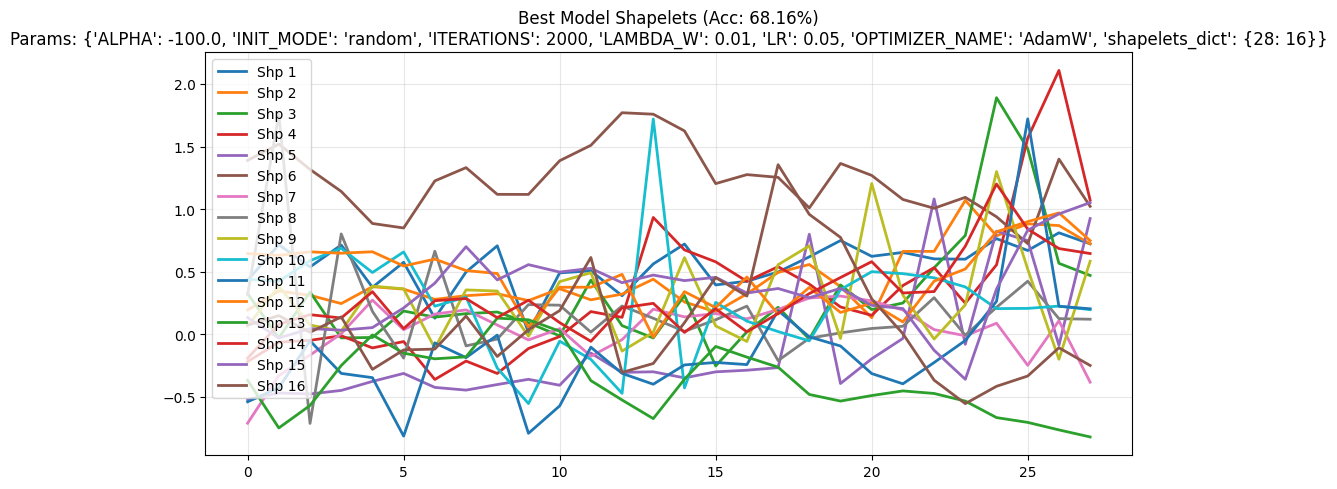

In [ ]:
# Final Comparison Table
# Extract best PyTorch result
best_pt_row = df_grid.loc[df_grid['test_acc'].idxmax()]

comparison_row = {
    "model": f"ShapeNet (Best)",
    "test_acc": best_pt_row['test_acc'],
    "test_bal_acc": best_pt_row['test_bal_acc'],
    "test_f1_macro": best_pt_row['test_f1_macro'],
    "total_time_s": best_pt_row['total_time_s']
}

# Combine
final_comparison = pd.concat([df_baselines, pd.DataFrame([comparison_row])], ignore_index=True)
final_comparison = final_comparison.sort_values("test_acc", ascending=False)

print("\n" + "="*30)
print("FINAL STUDY RESULTS")
print("="*30)
print(final_comparison.to_string(index=False))

# Optional: Plot Best Shapelets
if best_run:
    visualize_best_shapelets(best_run)

## Conclusion

We have successfully implemented a differentiable Shapelet Learning model in PyTorch. Our experiments demonstrate that:

- Optimization matters: AdamW + Random Window Initialization yields significantly better convergence than standard SGD + Noise.
- Architecture: The modular block design allows efficient multi-scale learning.
- Performance: The model outperforms 1NN-Euclidean and rivals 1NN-DTW on complex multiclass tasks while remaining interpretable.